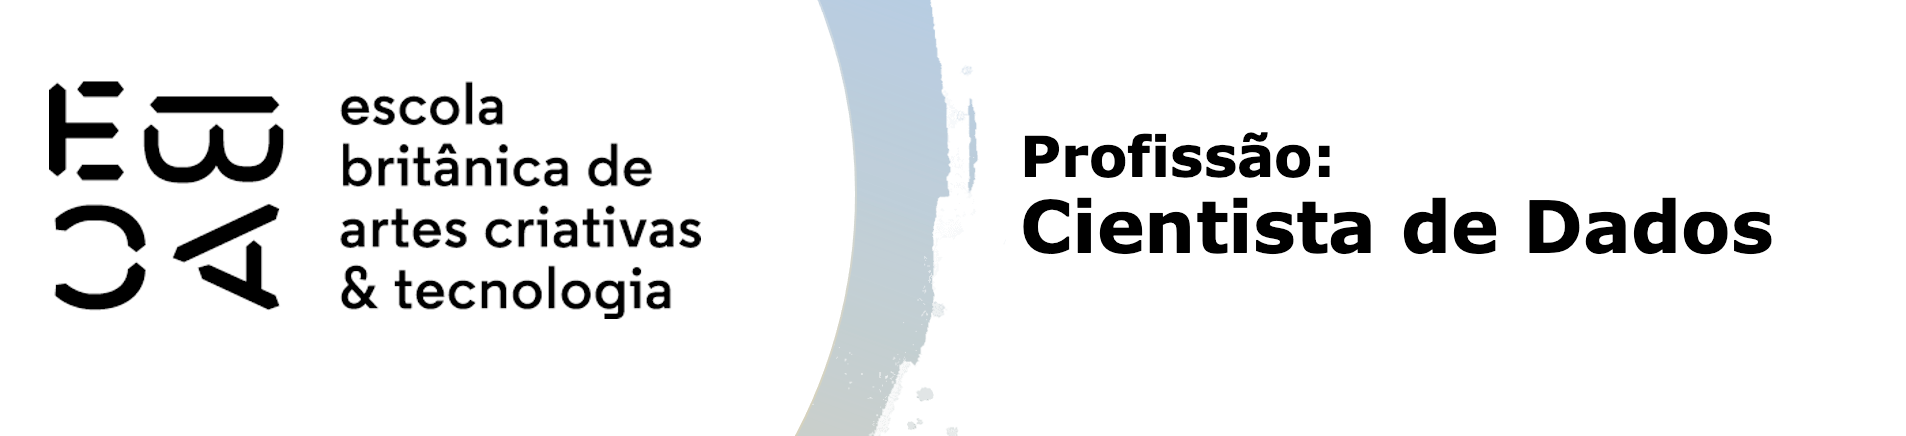

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import setup, compare_models, pull, plot_model, predict_model,create_model, tune_model, save_model, finalize_model
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Garantir que a coluna 'data_ref' está no formato datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenar pelo 'data_ref' para garantir ordem cronológica
df = df.sort_values(by='data_ref')

# Identificar os três últimos meses
oot_months = df['data_ref'].unique()[-3:]  # Os três últimos meses únicos

# Separar os conjuntos de treinamento e oot
df_oot = df[df['data_ref'].isin(oot_months)].reset_index(drop=True)
df_train = df[~df['data_ref'].isin(oot_months)].reset_index(drop=True)

# Remover as variáveis não explicativas
variaveis_explicativas = df.columns.difference(['data_ref', 'index', 'mau'])

# Visualizar o resultado
print("Conjunto de Treinamento:")
print(df_train['data_ref'].value_counts())

print("\nConjunto Out of Time (OOT):")
print(df_oot['data_ref'].value_counts())

print("\nVariáveis explicativas:")
print(variaveis_explicativas.tolist())

Conjunto de Treinamento:
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
Name: data_ref, dtype: int64

Conjunto Out of Time (OOT):
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

Variáveis explicativas:
['educacao', 'estado_civil', 'idade', 'posse_de_imovel', 'posse_de_veiculo', 'qt_pessoas_residencia', 'qtd_filhos', 'renda', 'sexo', 'tempo_emprego', 'tipo_renda', 'tipo_residencia']


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Número total de linhas
total_linhas = len(df)
print(f"Total de linhas: {total_linhas}")

# Número de linhas por mês em data_ref
linhas_por_mes = df['data_ref'].value_counts().sort_index()
print("\nNúmero de linhas por mês:")
print(linhas_por_mes)

# Separar variáveis qualitativas e quantitativas
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
variaveis_quantitativas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']

# Análise descritiva para variáveis qualitativas
print("\nAnálise descritiva - Variáveis Qualitativas:")
for var in variaveis_qualitativas:
    print(f"\n{var}:")
    freq_abs = df[var].value_counts()
    freq_rel = df[var].value_counts(normalize=True) * 100
    resumo = pd.DataFrame({'Frequência Absoluta': freq_abs, 'Frequência Relativa (%)': freq_rel})
    print(resumo)

# Análise descritiva para variáveis quantitativas
print("\nAnálise descritiva - Variáveis Quantitativas:")
resumo_quantitativas = df[variaveis_quantitativas].describe().T
print(resumo_quantitativas)

Total de linhas: 750000

Número de linhas por mês:
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

Análise descritiva - Variáveis Qualitativas:

sexo:
   Frequência Absoluta  Frequência Relativa (%)
F               504580                67.277333
M               245420                32.722667

posse_de_veiculo:
   Frequência Absoluta  Frequência Relativa (%)
N               457954                61.060533
S               292046                38.939467

posse_de_imovel:
   Frequência Absoluta  Frequência Relativa (%)
S               503692                67.158933
N               246308                32.841067

tipo_renda:
                  Frequência Absoluta  Frequência Relativa (%)
Assalariado           

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


Cruzamento: sexo vs posse_de_veiculo
posse_de_veiculo          N          S
sexo                                  
F                 73.532046  26.467954
M                 35.419281  64.580719


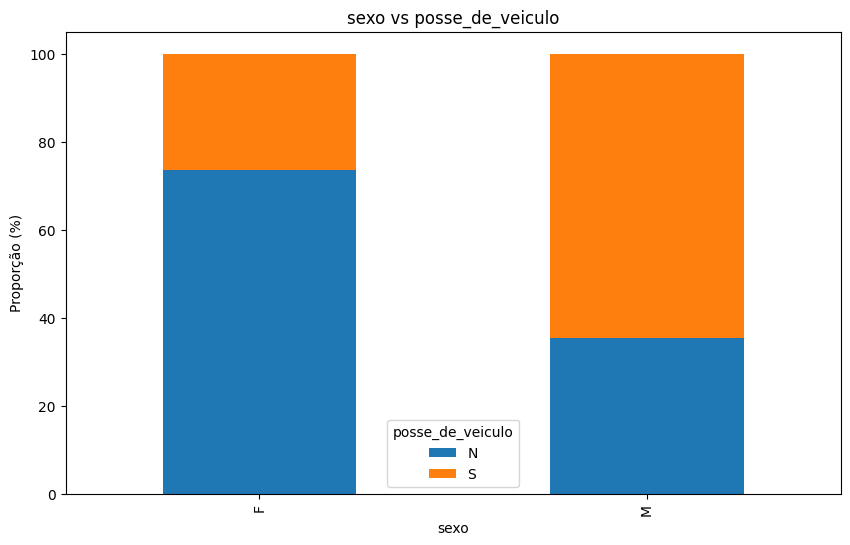


Cruzamento: sexo vs posse_de_imovel
posse_de_imovel          N          S
sexo                                 
F                31.048000  68.952000
M                36.527585  63.472415


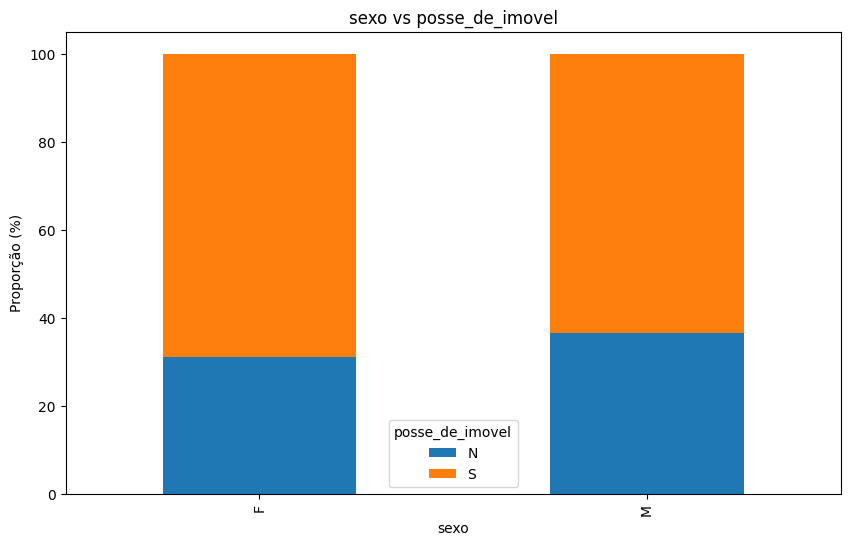


Cruzamento: sexo vs tipo_renda
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F             46.651671  0.071545   22.548258    21.407111          9.321416
M             61.260288  0.000000   24.015158     7.435824          7.288730


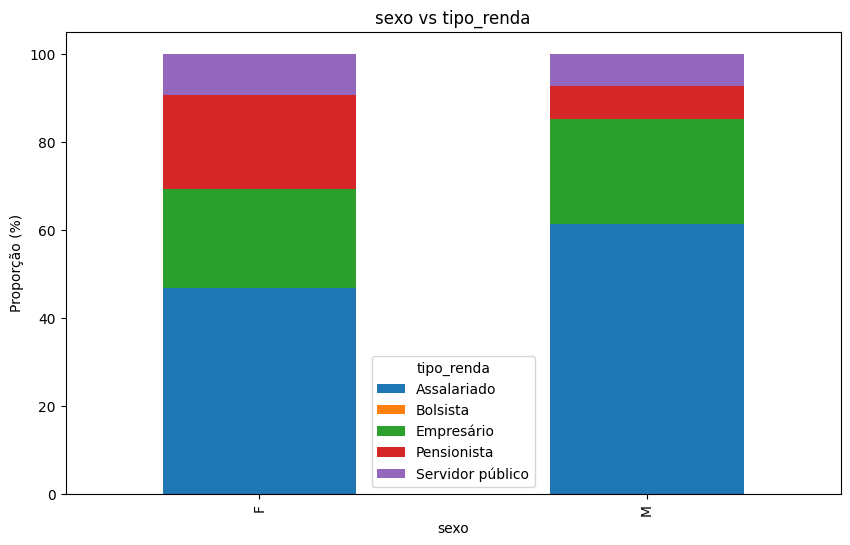


Cruzamento: sexo vs educacao
educacao  Fundamental      Médio  Pós graduação  Superior completo  \
sexo                                                                 
F            1.070792  67.812042       0.117127          27.339966   
M            1.292478  67.097221       0.090050          27.036916   

educacao  Superior incompleto  
sexo                           
F                    3.660074  
M                    4.483335  


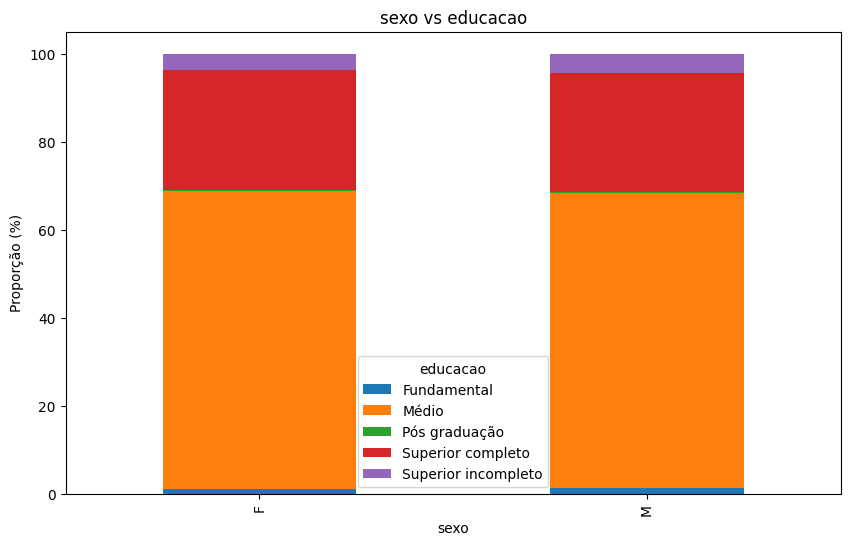


Cruzamento: sexo vs estado_civil
estado_civil     Casado  Separado   Solteiro     União     Viúvo
sexo                                                            
F             65.993698  6.686948  13.016172  8.136272  6.166911
M             78.836688  3.597914  10.586749  6.776546  0.202103


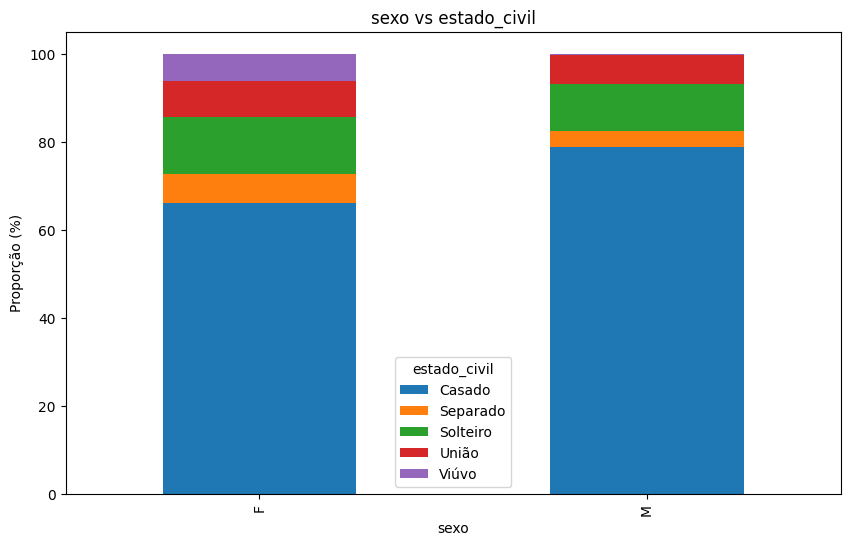


Cruzamento: sexo vs tipo_residencia
tipo_residencia   Aluguel       Casa  Com os pais  Comunitário   Estúdio  \
sexo                                                                       
F                0.985969  91.214277     3.653335     0.346427  0.403702   
M                2.189716  87.215793     6.029663     0.628311  1.368267   

tipo_residencia  Governamental  
sexo                            
F                      3.39629  
M                      2.56825  


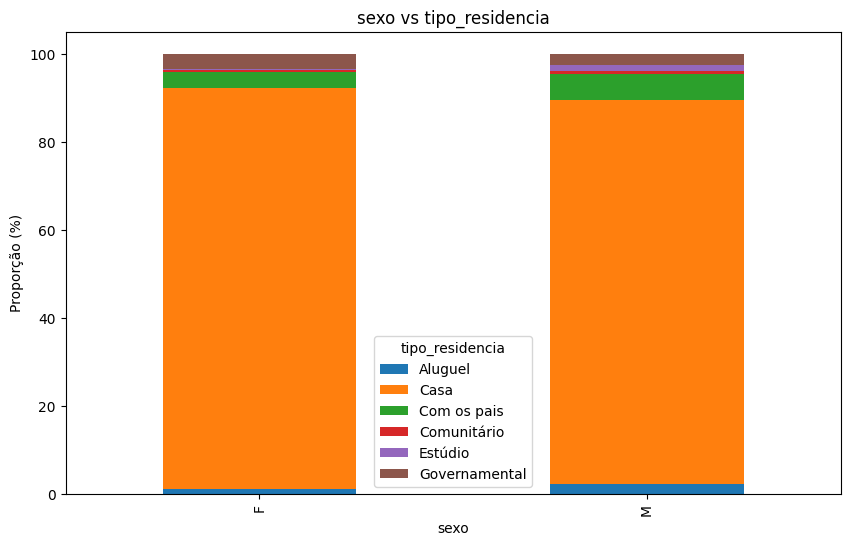


Cruzamento: posse_de_veiculo vs sexo
sexo                      F          M
posse_de_veiculo                      
N                 81.018618  18.981382
S                 45.729782  54.270218


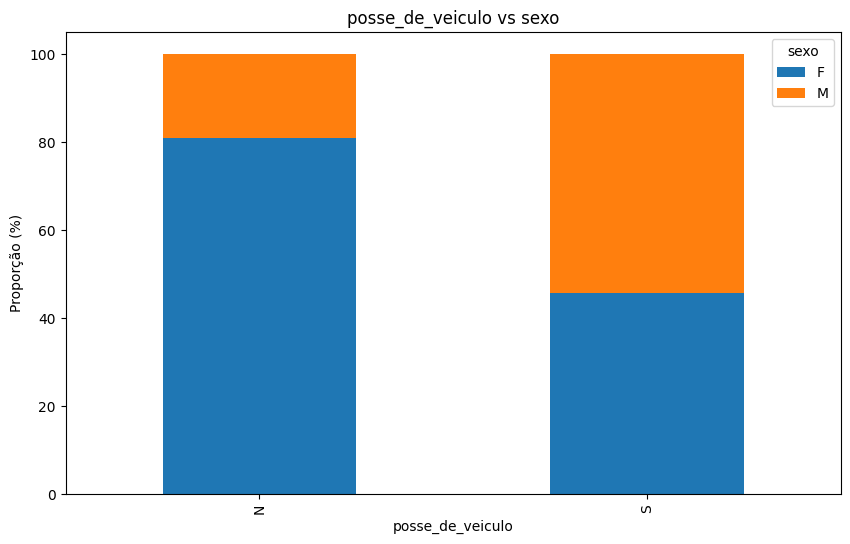


Cruzamento: posse_de_veiculo vs posse_de_imovel
posse_de_imovel           N          S
posse_de_veiculo                      
N                 31.889011  68.110989
S                 34.333975  65.666025


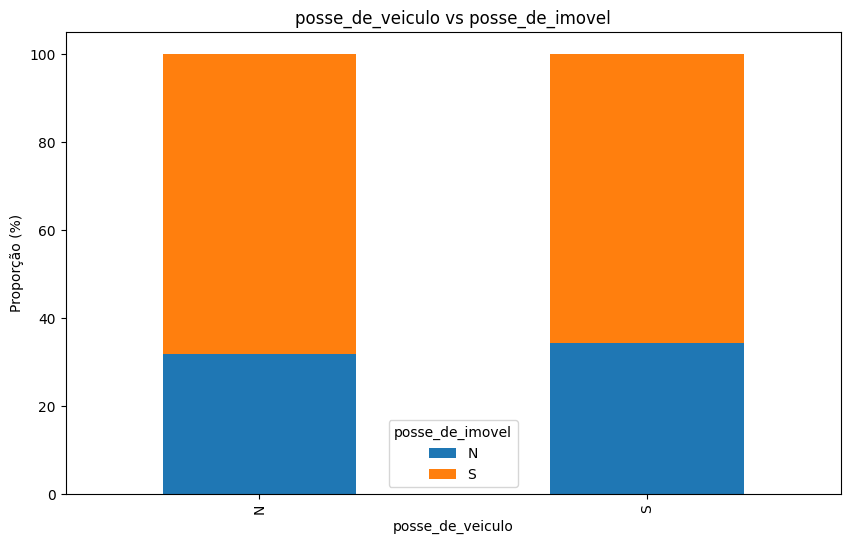


Cruzamento: posse_de_veiculo vs tipo_renda
tipo_renda        Assalariado  Bolsista  Empresário  Pensionista  \
posse_de_veiculo                                                   
N                   48.557715  0.078829   21.357167    21.314368   
S                   55.939133  0.000000   25.648699     9.811810   

tipo_renda        Servidor público  
posse_de_veiculo                    
N                         8.691921  
S                         8.600357  


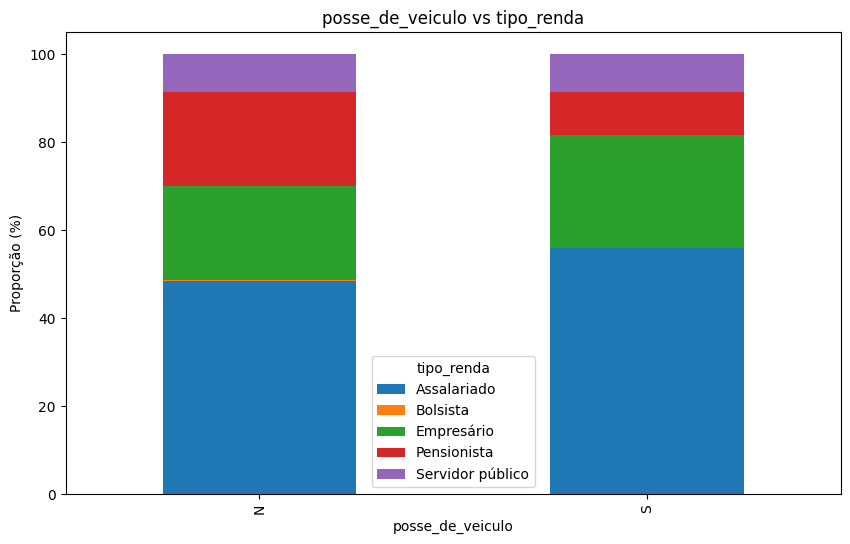


Cruzamento: posse_de_veiculo vs educacao
educacao          Fundamental      Médio  Pós graduação  Superior completo  \
posse_de_veiculo                                                             
N                    1.304498  71.503251       0.061142          23.481616   
S                    0.890613  61.423200       0.182163          33.135533   

educacao          Superior incompleto  
posse_de_veiculo                       
N                            3.649493  
S                            4.368490  


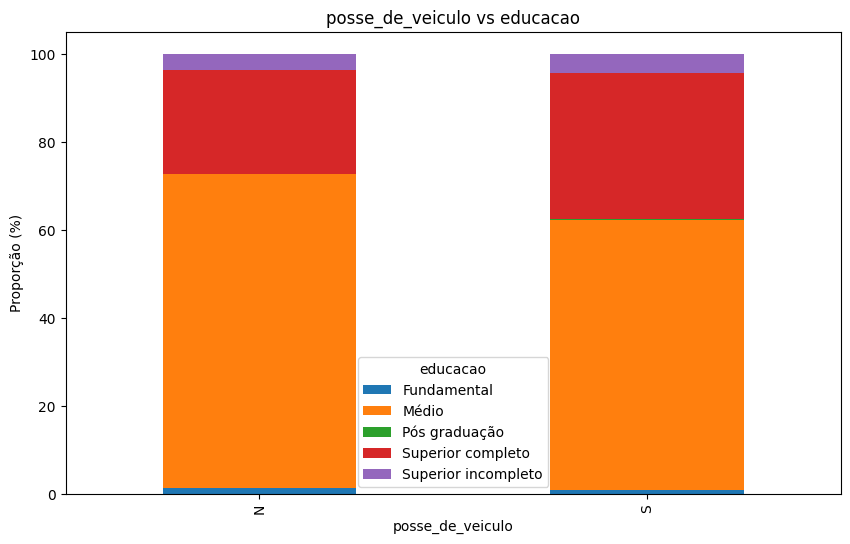


Cruzamento: posse_de_veiculo vs estado_civil
estado_civil         Casado  Separado   Solteiro     União     Viúvo
posse_de_veiculo                                                    
N                 64.405159  7.102023  14.359958  8.420496  5.712364
S                 79.277237  3.440211   8.867439  6.547941  1.867172


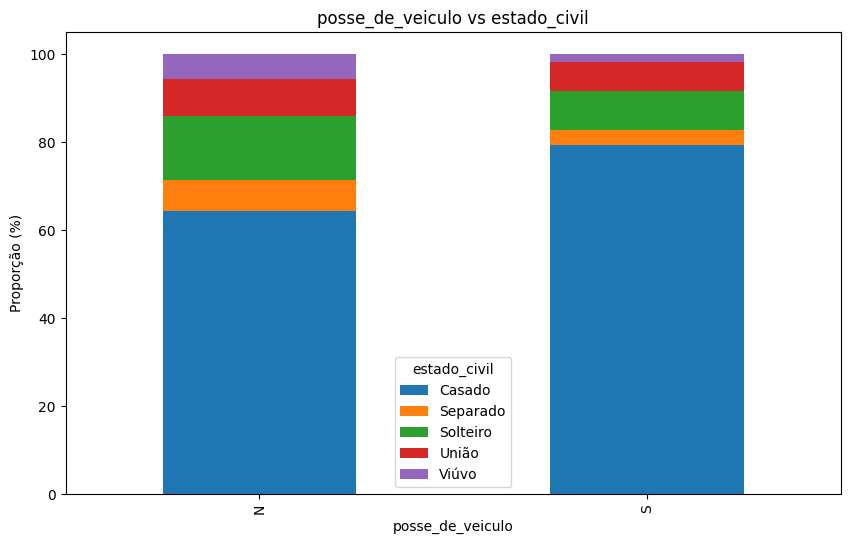


Cruzamento: posse_de_veiculo vs tipo_residencia
tipo_residencia    Aluguel       Casa  Com os pais  Comunitário   Estúdio  \
posse_de_veiculo                                                            
N                 1.314979  90.433319     4.070496     0.287365  0.502015   
S                 1.481616  89.078775     4.996131     0.675921  1.060107   

tipo_residencia   Governamental  
posse_de_veiculo                 
N                      3.391825  
S                      2.707450  


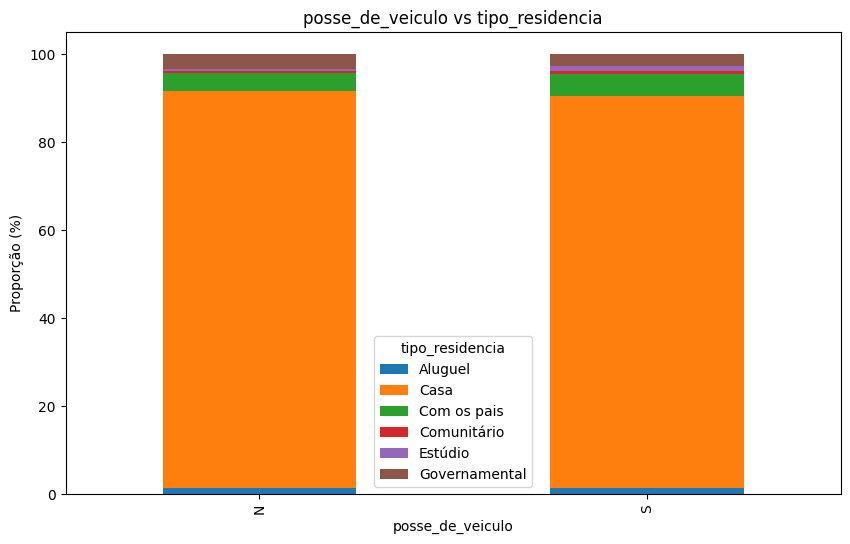


Cruzamento: posse_de_imovel vs sexo
sexo                     F          M
posse_de_imovel                      
N                63.604105  36.395895
S                69.073561  30.926439


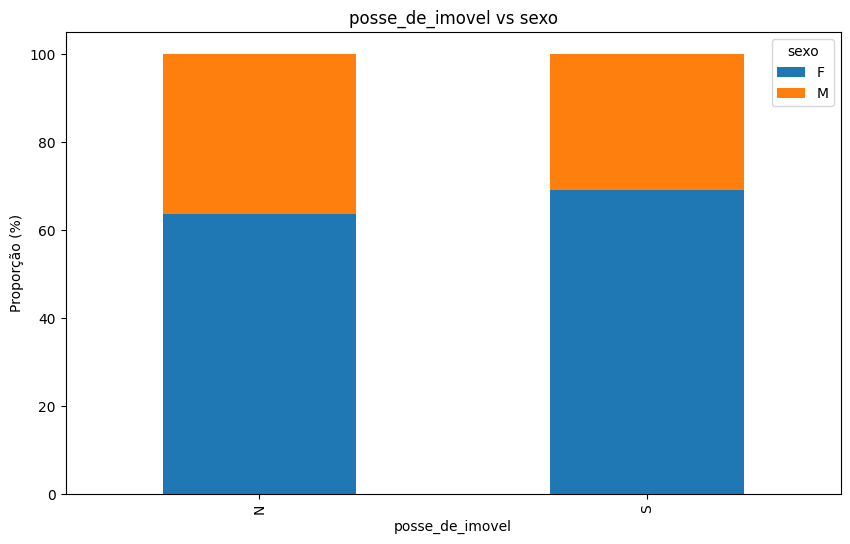


Cruzamento: posse_de_imovel vs posse_de_veiculo
posse_de_veiculo          N          S
posse_de_imovel                       
N                 59.290401  40.709599
S                 61.926137  38.073863


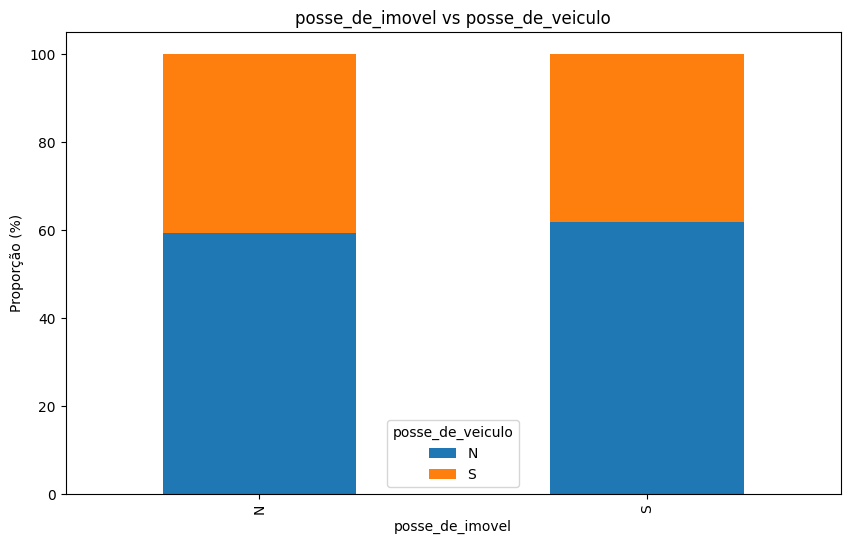


Cruzamento: posse_de_imovel vs tipo_renda
tipo_renda       Assalariado  Bolsista  Empresário  Pensionista  \
posse_de_imovel                                                   
N                  55.017295  0.000000   23.942381    11.615538   
S                  49.678772  0.071671   22.581260    19.387840   

tipo_renda       Servidor público  
posse_de_imovel                    
N                        9.424785  
S                        8.280457  


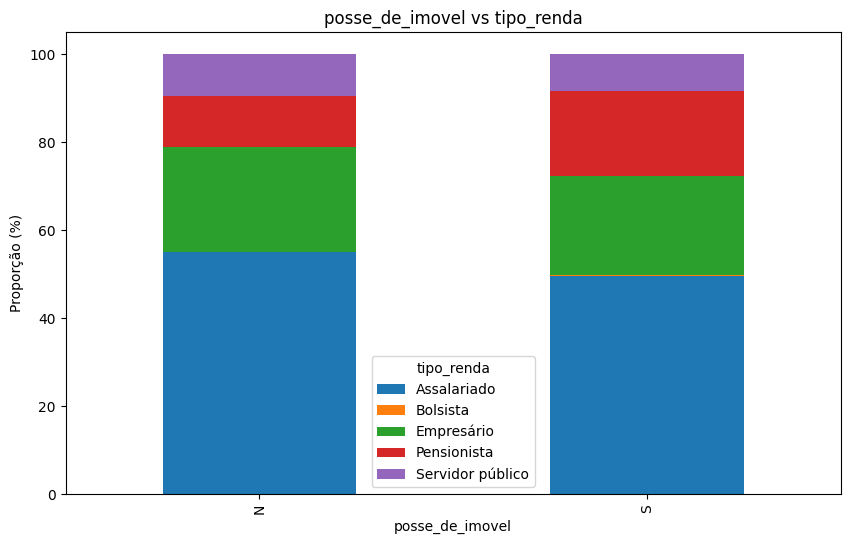


Cruzamento: posse_de_imovel vs educacao
educacao         Fundamental      Médio  Pós graduação  Superior completo  \
posse_de_imovel                                                             
N                   0.779918  66.546763        0.00000          27.475356   
S                   1.321045  68.082479        0.16121          27.126101   

educacao         Superior incompleto  
posse_de_imovel                       
N                           5.197964  
S                           3.309165  


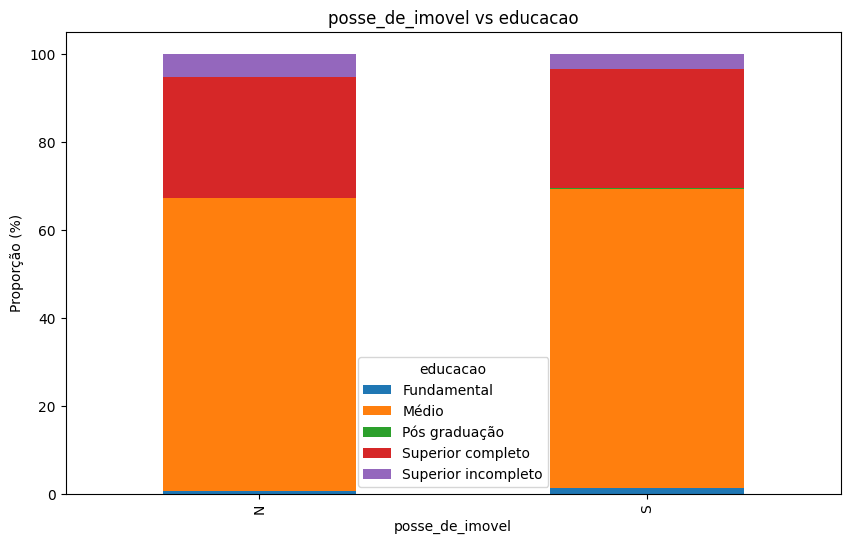


Cruzamento: posse_de_imovel vs estado_civil
estado_civil        Casado  Separado   Solteiro     União     Viúvo
posse_de_imovel                                                    
N                69.695666  6.257612  12.000828  8.964386  3.081508
S                70.441063  5.391787  12.328963  7.068804  4.769383


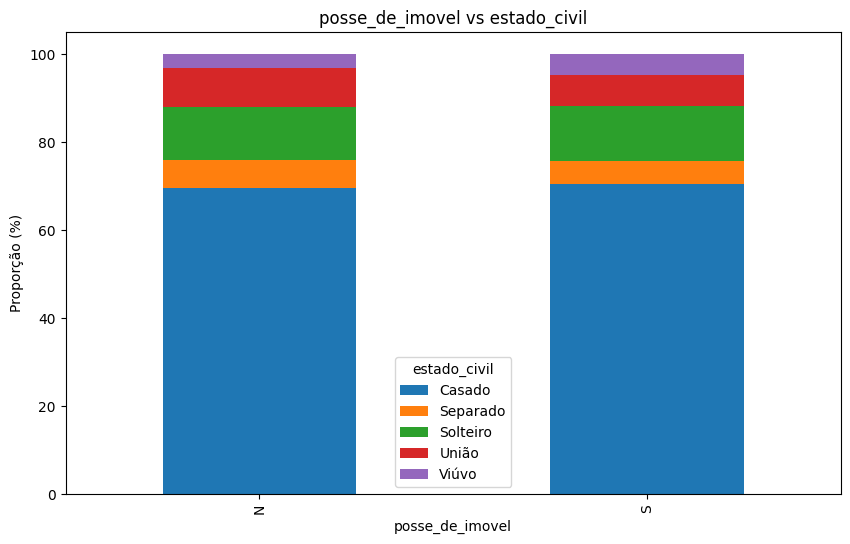


Cruzamento: posse_de_imovel vs tipo_residencia
tipo_residencia   Aluguel       Casa  Com os pais  Comunitário   Estúdio  \
posse_de_imovel                                                            
N                1.807493  81.206863     9.028127     0.629293  1.172922   
S                1.170755  94.159725     2.182882     0.345449  0.497526   

tipo_residencia  Governamental  
posse_de_imovel                 
N                     6.155301  
S                     1.643663  


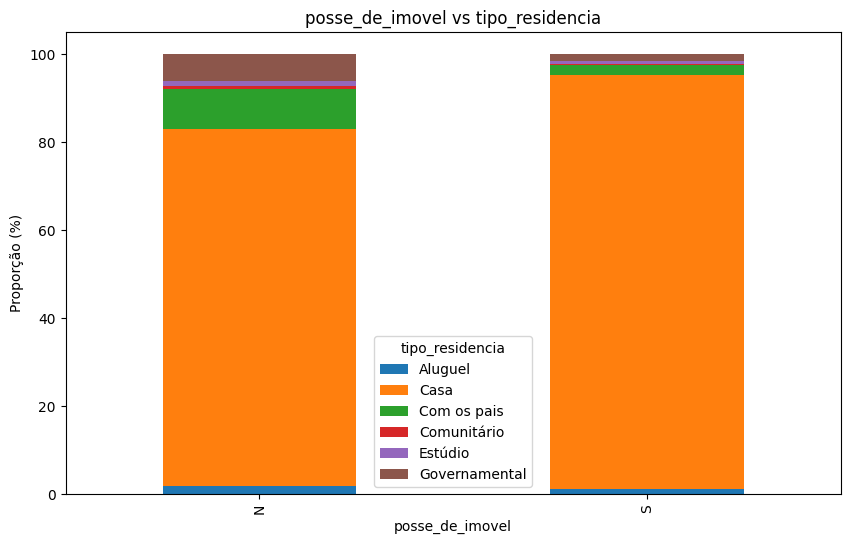


Cruzamento: tipo_renda vs sexo
sexo                       F          M
tipo_renda                             
Assalariado        61.024265  38.975735
Bolsista          100.000000   0.000000
Empresário         65.874983  34.125017
Pensionista        85.547064  14.452936
Servidor público   72.446936  27.553064


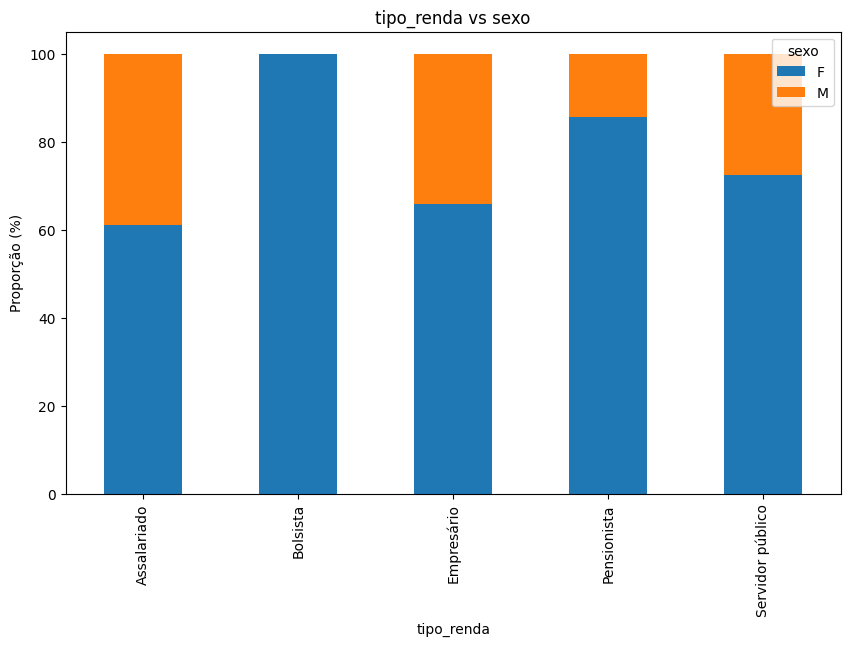


Cruzamento: tipo_renda vs posse_de_veiculo
posse_de_veiculo           N          S
tipo_renda                             
Assalariado        57.648157  42.351843
Bolsista          100.000000   0.000000
Empresário         56.629534  43.370466
Pensionista        77.305667  22.694333
Servidor público   61.312036  38.687964


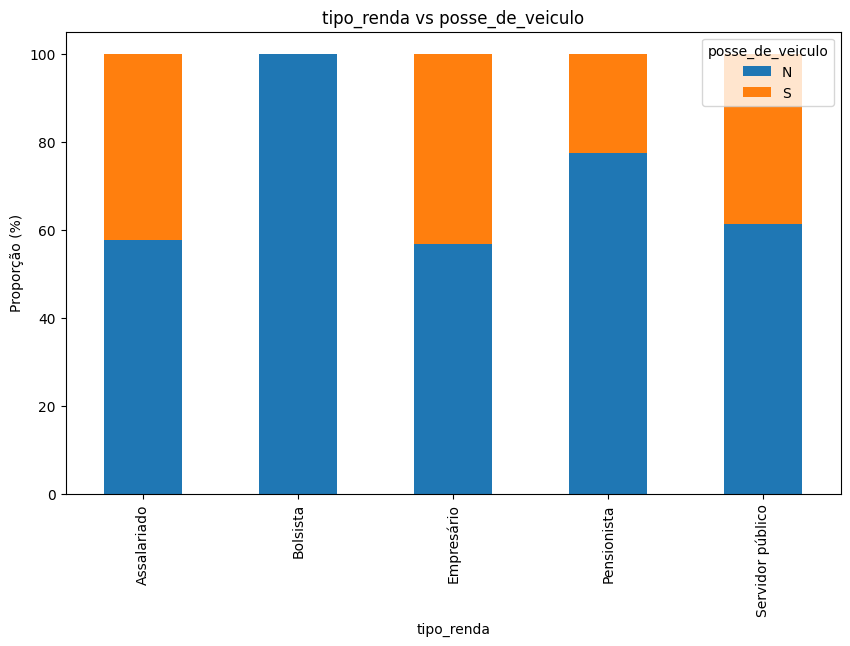


Cruzamento: tipo_renda vs posse_de_imovel
posse_de_imovel           N           S
tipo_renda                             
Assalariado       35.130399   64.869601
Bolsista           0.000000  100.000000
Empresário        34.144703   65.855297
Pensionista       22.658694   77.341306
Servidor público  35.756754   64.243246


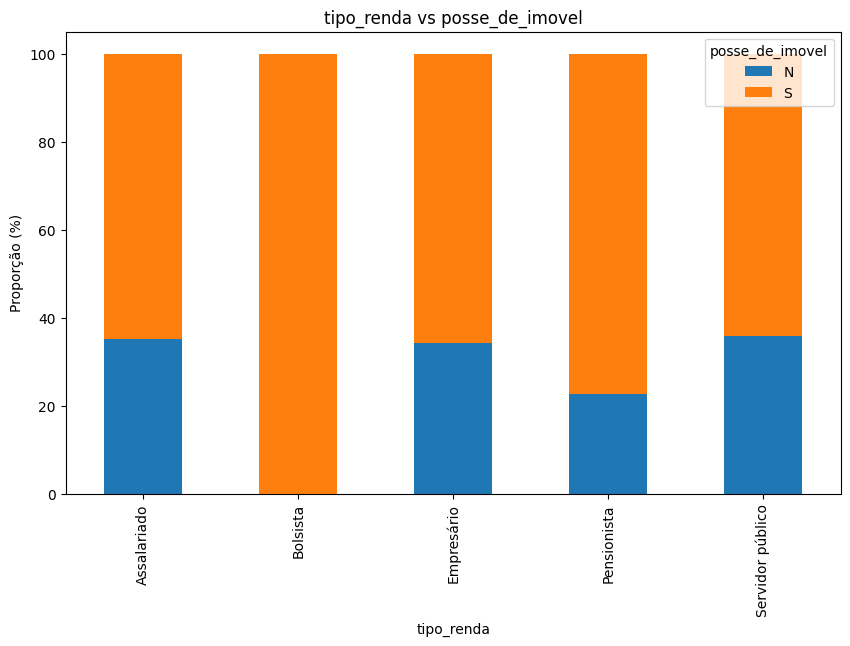


Cruzamento: tipo_renda vs educacao
educacao          Fundamental      Médio  Pós graduação  Superior completo  \
tipo_renda                                                                   
Assalariado          1.013895  69.990408       0.104475          24.668430   
Bolsista             0.000000   0.000000       0.000000         100.000000   
Empresário           0.398351  59.349669       0.236810          34.405253   
Pensionista          2.904209  79.177919       0.000000          16.897794   
Servidor público     0.475956  52.951234       0.000000          43.176427   

educacao          Superior incompleto  
tipo_renda                             
Assalariado                  4.222793  
Bolsista                     0.000000  
Empresário                   5.609917  
Pensionista                  1.020077  
Servidor público             3.396383  


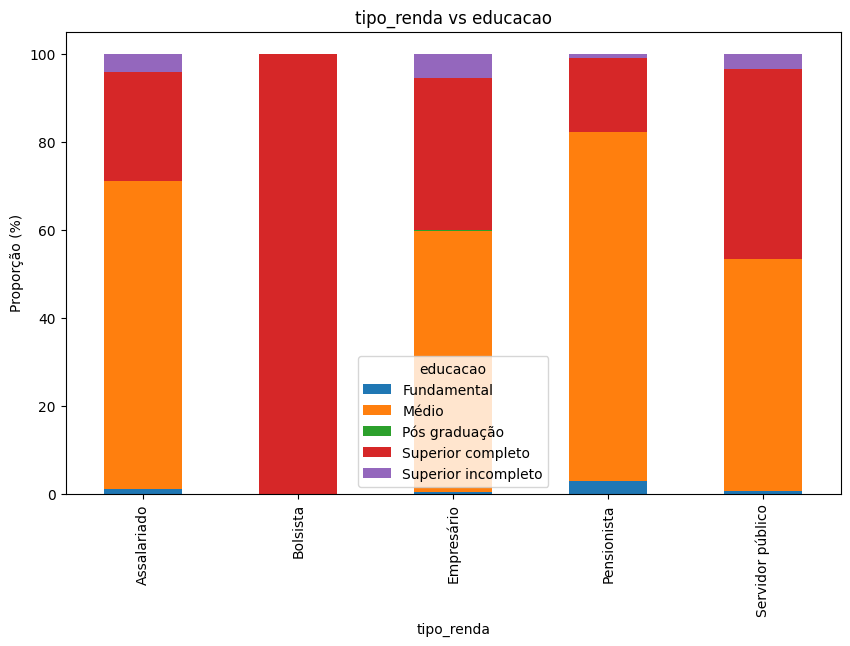


Cruzamento: tipo_renda vs estado_civil
estado_civil          Casado  Separado   Solteiro     União      Viúvo
tipo_renda                                                            
Assalariado        72.317883  5.900866  11.736921  7.456058   2.588272
Bolsista          100.000000  0.000000   0.000000  0.000000   0.000000
Empresário         68.560957  6.038376  14.552550  9.414517   1.433600
Pensionista        64.536491  5.010890  10.900883  6.101453  13.450283
Servidor público   72.782724  4.702566  11.532300  7.639937   3.342473


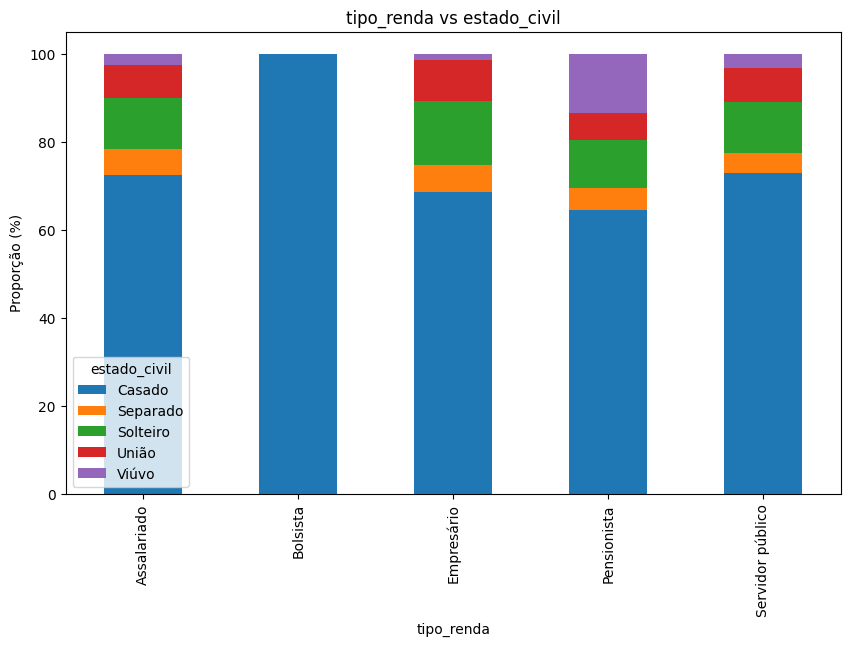


Cruzamento: tipo_renda vs tipo_residencia
tipo_residencia    Aluguel        Casa  Com os pais  Comunitário   Estúdio  \
tipo_renda                                                                   
Assalariado       1.661223   88.470991     5.505781     0.658215  0.541556   
Bolsista          0.000000  100.000000     0.000000     0.000000  0.000000   
Empresário        1.473551   89.586711     4.927857     0.177753  0.838969   
Pensionista       0.496575   96.051954     0.070487     0.000000  0.506870   
Servidor público  1.184498   87.270879     5.227812     0.683898  1.874557   

tipo_residencia   Governamental  
tipo_renda                       
Assalariado            3.162234  
Bolsista               0.000000  
Empresário             2.995160  
Pensionista            2.874114  
Servidor público       3.758356  


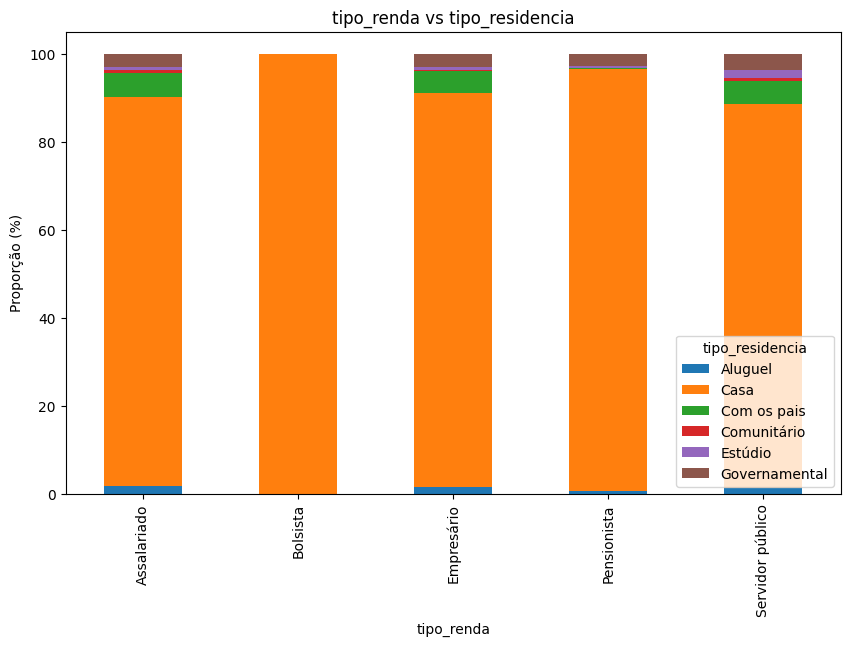


Cruzamento: educacao vs sexo
sexo                         F          M
educacao                                 
Fundamental          63.008746  36.991254
Médio                67.510201  32.489799
Pós graduação        72.783251  27.216749
Superior completo    67.522246  32.477754
Superior incompleto  62.664993  37.335007


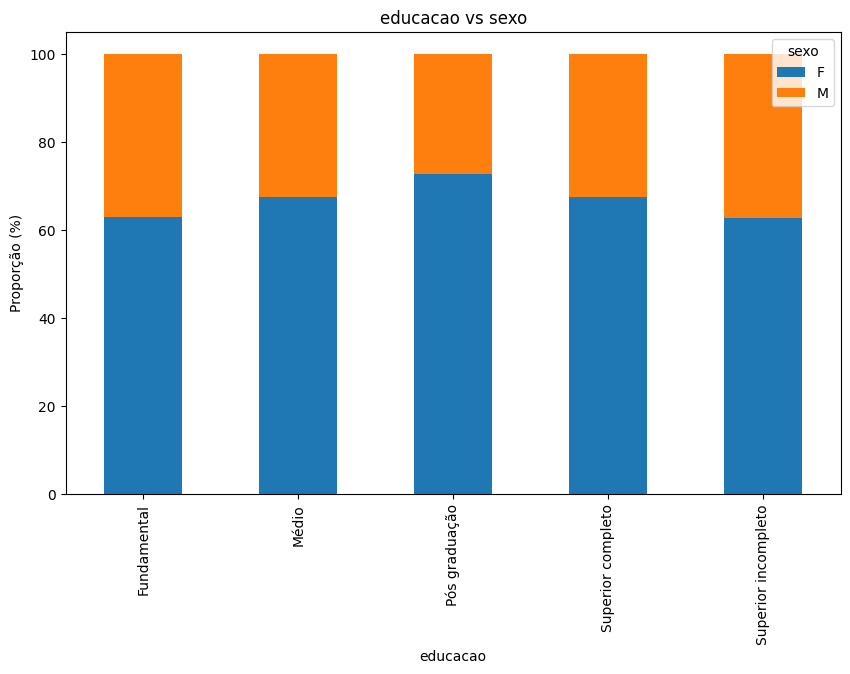


Cruzamento: educacao vs posse_de_veiculo
posse_de_veiculo             N          S
educacao                                 
Fundamental          69.667638  30.332362
Médio                64.607092  35.392908
Pós graduação        34.482759  65.517241
Superior completo    52.634284  47.365716
Superior incompleto  56.709986  43.290014


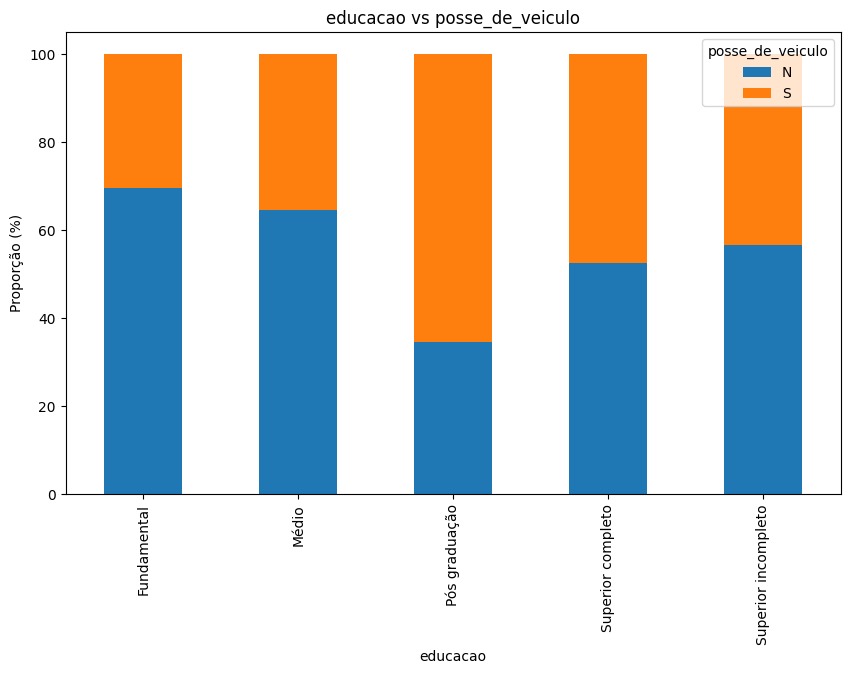


Cruzamento: educacao vs posse_de_imovel
posse_de_imovel              N           S
educacao                                  
Fundamental          22.402332   77.597668
Médio                32.339850   67.660150
Pós graduação         0.000000  100.000000
Superior completo    33.123844   66.876156
Superior incompleto  43.442706   56.557294


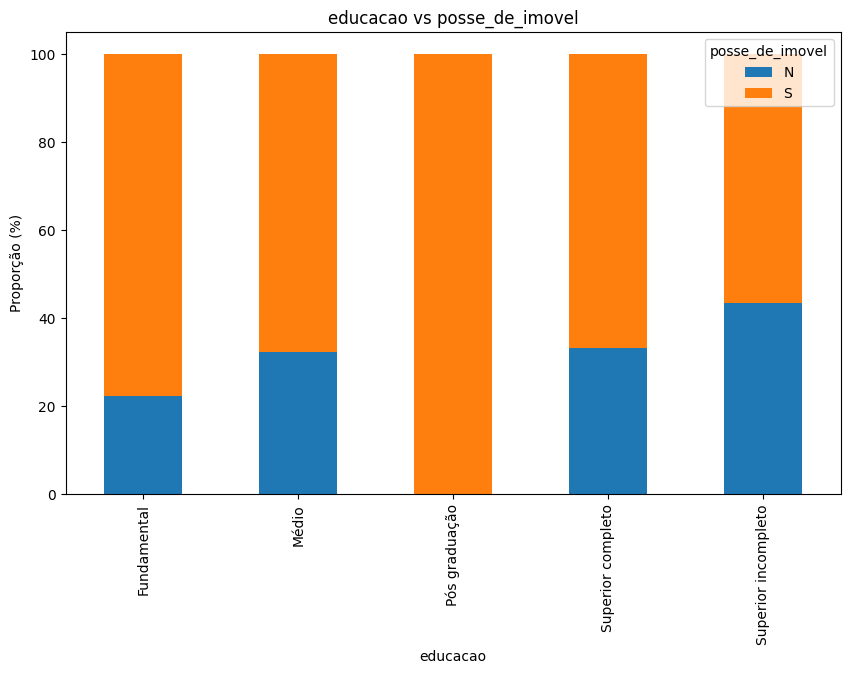


Cruzamento: educacao vs tipo_renda
tipo_renda           Assalariado  Bolsista  Empresário  Pensionista  \
educacao                                                              
Fundamental            45.609329  0.000000    8.023324    42.763848   
Médio                  53.267921  0.000000   20.224293    19.725118   
Pós graduação          49.630542  0.000000   50.369458     0.000000   
Superior completo      46.575235  0.176696   29.084804    10.443159   
Superior incompleto    55.271284  0.000000   32.876387     4.370398   

tipo_renda           Servidor público  
educacao                               
Fundamental                  3.603499  
Médio                        6.782667  
Pós graduação                0.000000  
Superior completo           13.720106  
Superior incompleto          7.481931  


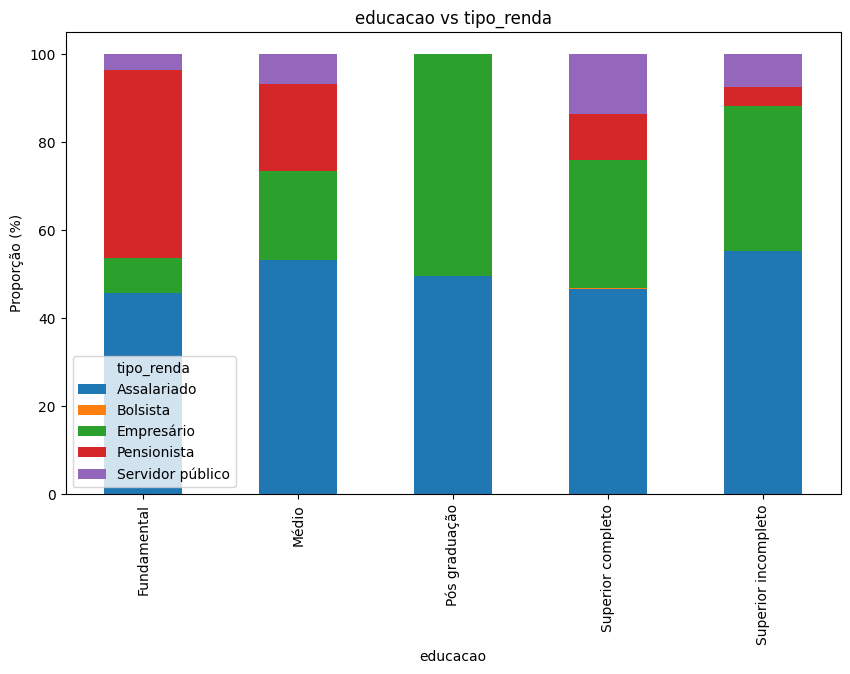


Cruzamento: educacao vs estado_civil
estado_civil            Casado  Separado   Solteiro     União     Viúvo
educacao                                                               
Fundamental          72.874636  5.271137   9.306122  8.769679  3.778426
Médio                70.156027  5.571427  11.200270  8.087034  4.985242
Pós graduação        71.551724  0.000000  22.660099  5.788177  0.000000
Superior completo    70.797725  6.271475  14.029446  6.341468  2.559886
Superior incompleto  65.902073  3.623901  17.803943  9.982695  2.687388


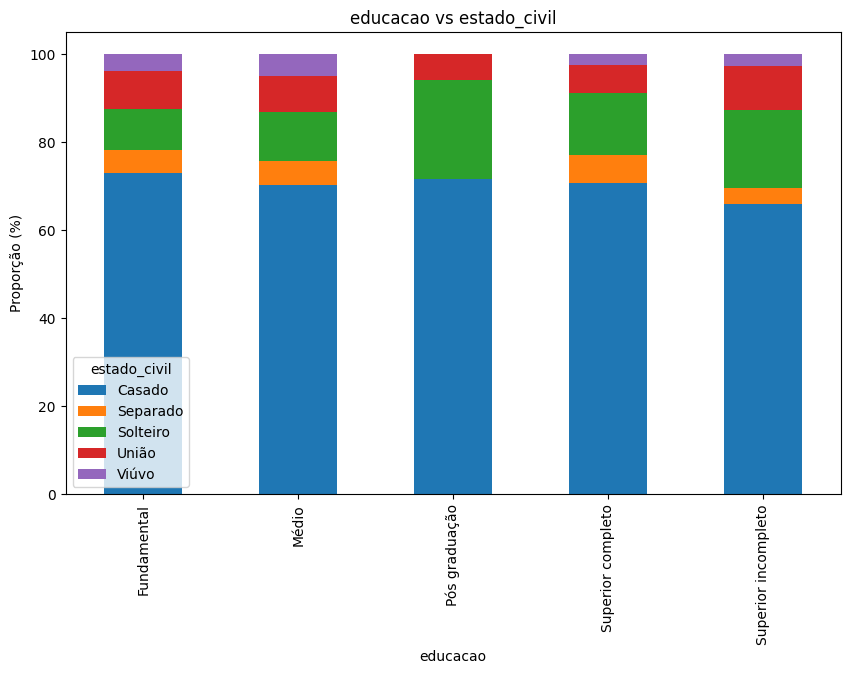


Cruzamento: educacao vs tipo_residencia
tipo_residencia       Aluguel        Casa  Com os pais  Comunitário   Estúdio  \
educacao                                                                        
Fundamental          0.967930   87.288630     5.586006     2.682216  0.000000   
Médio                1.491804   90.184794     3.733160     0.209930  0.623081   
Pós graduação        0.000000  100.000000     0.000000     0.000000  0.000000   
Superior completo    0.908931   90.069308     5.351287     0.815933  0.997034   
Superior incompleto  2.877405   84.459299     9.836789     1.116352  0.678633   

tipo_residencia      Governamental  
educacao                            
Fundamental               3.475219  
Médio                     3.757231  
Pós graduação             0.000000  
Superior completo         1.857508  
Superior incompleto       1.031523  


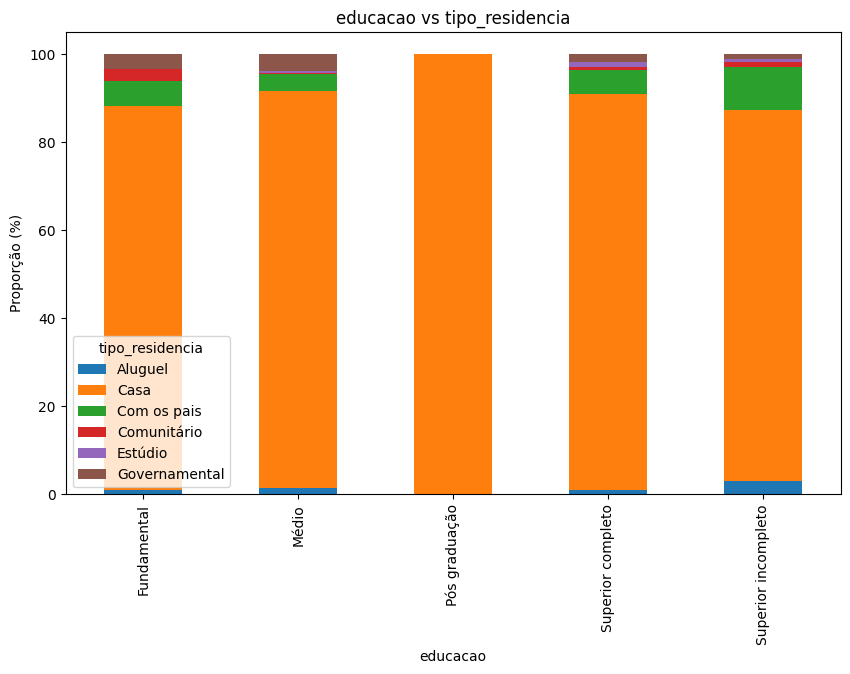


Cruzamento: estado_civil vs sexo
sexo                  F          M
estado_civil                      
Casado        63.249518  36.750482
Separado      79.258180  20.741820
Solteiro      71.653629  28.346371
União         71.169281  28.830719
Viúvo         98.431025   1.568975


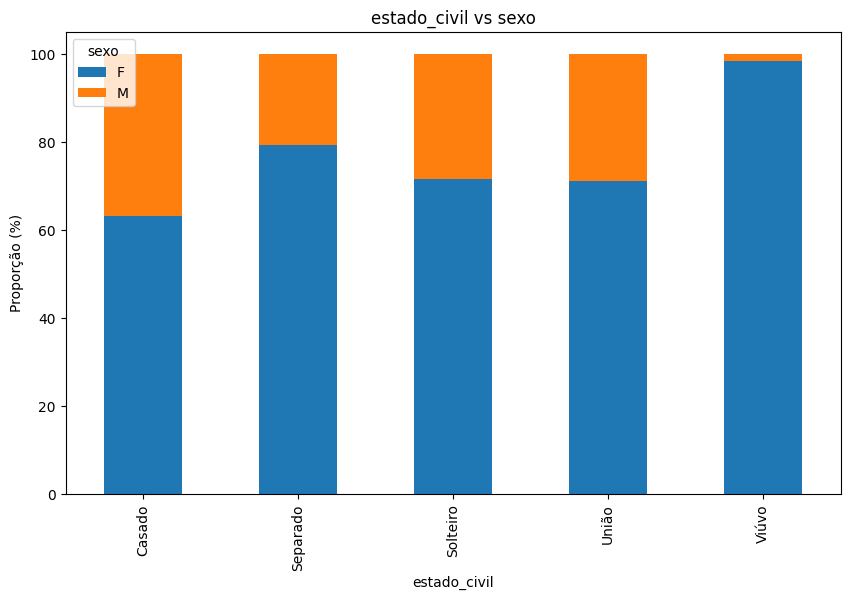


Cruzamento: estado_civil vs posse_de_veiculo
posse_de_veiculo          N          S
estado_civil                          
Casado            56.023112  43.976888
Separado          76.399427  23.600573
Solteiro          71.746364  28.253636
União             66.849268  33.150732
Viúvo             82.750767  17.249233


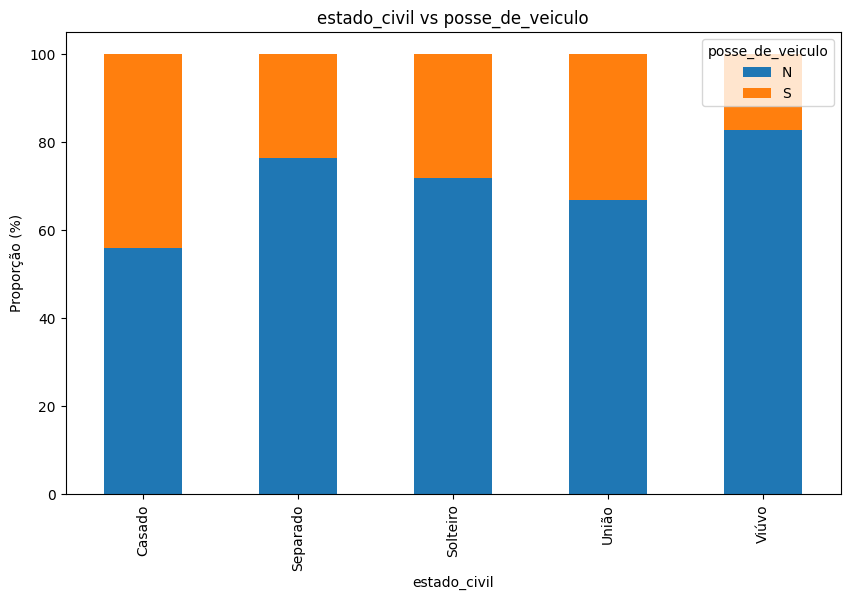


Cruzamento: estado_civil vs posse_de_imovel
posse_de_imovel          N          S
estado_civil                         
Casado           32.606862  67.393138
Separado         36.205398  63.794602
Solteiro         32.248879  67.751121
União            38.276848  61.723152
Viúvo            24.009110  75.990890


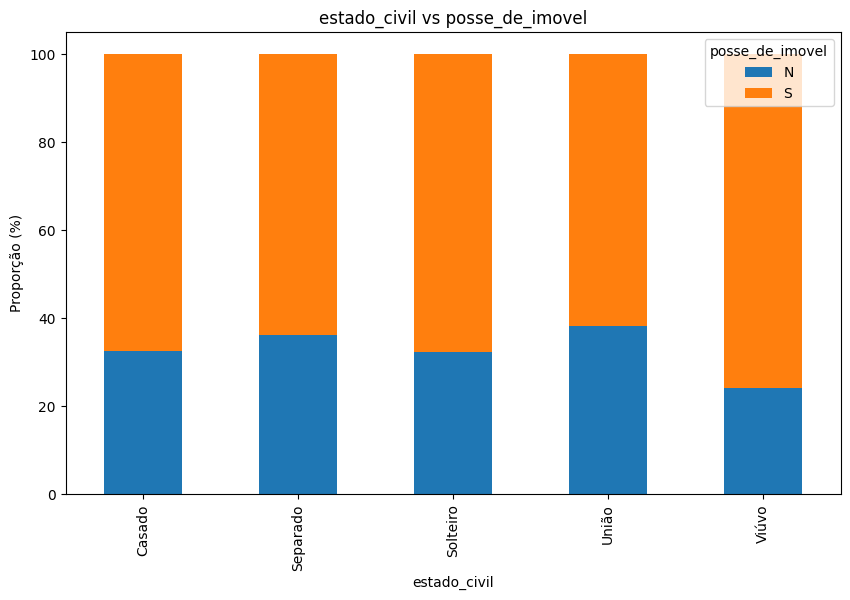


Cruzamento: estado_civil vs tipo_renda
tipo_renda    Assalariado  Bolsista  Empresário  Pensionista  Servidor público
estado_civil                                                                  
Casado          52.986484   0.06857   22.491794    15.477936          8.975216
Separado        53.468324   0.00000   24.497898    14.862230          7.171549
Solteiro        49.393949   0.00000   27.421203    15.016529          8.168320
União           49.858715   0.00000   28.187570    13.355292          8.598422
Viúvo           31.581944   0.00000    7.832221    53.721570          6.864265


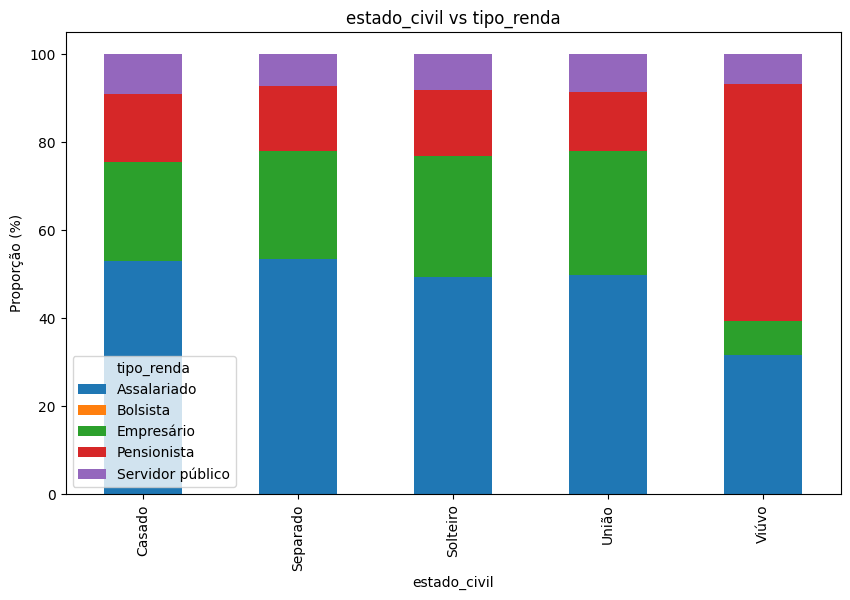


Cruzamento: estado_civil vs educacao
educacao      Fundamental      Médio  Pós graduação  Superior completo  \
estado_civil                                                             
Casado           1.186958  67.539394       0.110357          27.474206   
Separado         1.061756  66.331540       0.000000          30.097954   
Solteiro         0.870618  61.932816       0.200744          31.271343   
União            1.303632  71.054867       0.081477          22.459912   
Viúvo            1.024895  79.925980       0.000000          16.543827   

educacao      Superior incompleto  
estado_civil                       
Casado                   3.689085  
Separado                 2.508750  
Solteiro                 5.724479  
União                    5.100113  
Viúvo                    2.505298  


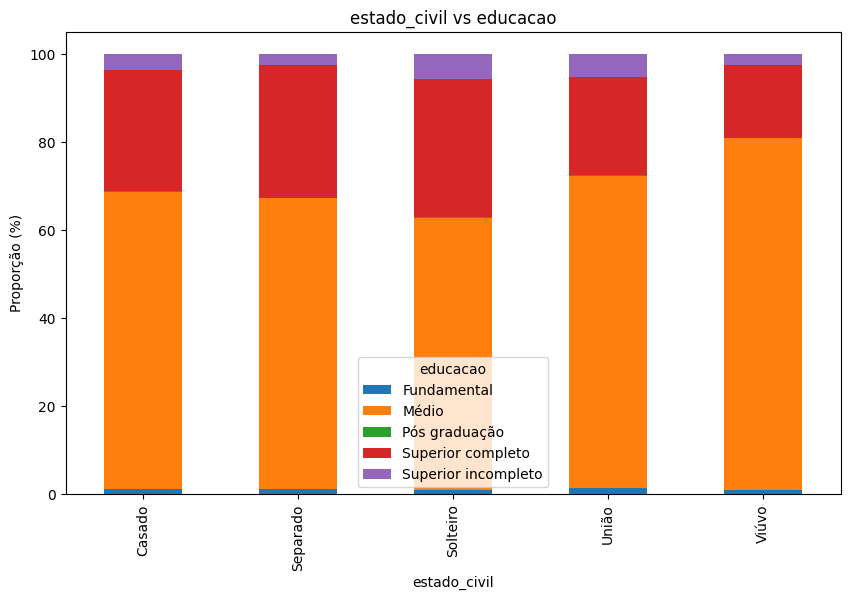


Cruzamento: estado_civil vs tipo_residencia
tipo_residencia   Aluguel       Casa  Com os pais  Comunitário   Estúdio  \
estado_civil                                                               
Casado           1.251728  90.319143     4.101453     0.487395  0.719127   
Separado         0.587254  89.481102     5.235959     0.300674  1.068803   
Solteiro         3.091895  86.019922     6.149969     0.396033  0.643690   
União            1.007194  89.600416     6.356939     0.078010  0.977724   
Viúvo            0.297346  95.419606     0.335305     0.594692  0.000000   

tipo_residencia  Governamental  
estado_civil                    
Casado                3.121154  
Separado              3.326208  
Solteiro              3.698491  
União                 1.979717  
Viúvo                 3.353051  


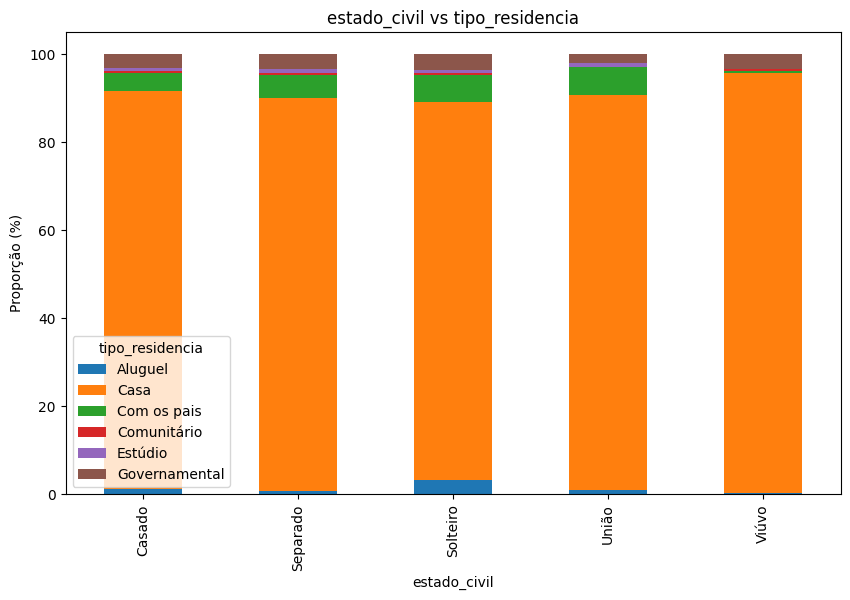


Cruzamento: tipo_residencia vs sexo
sexo                     F          M
tipo_residencia                      
Aluguel          48.072278  51.927722
Casa             68.256428  31.743572
Com os pais      55.470631  44.529369
Comunitário      53.130699  46.869301
Estúdio          37.757183  62.242817
Governamental    73.110068  26.889932


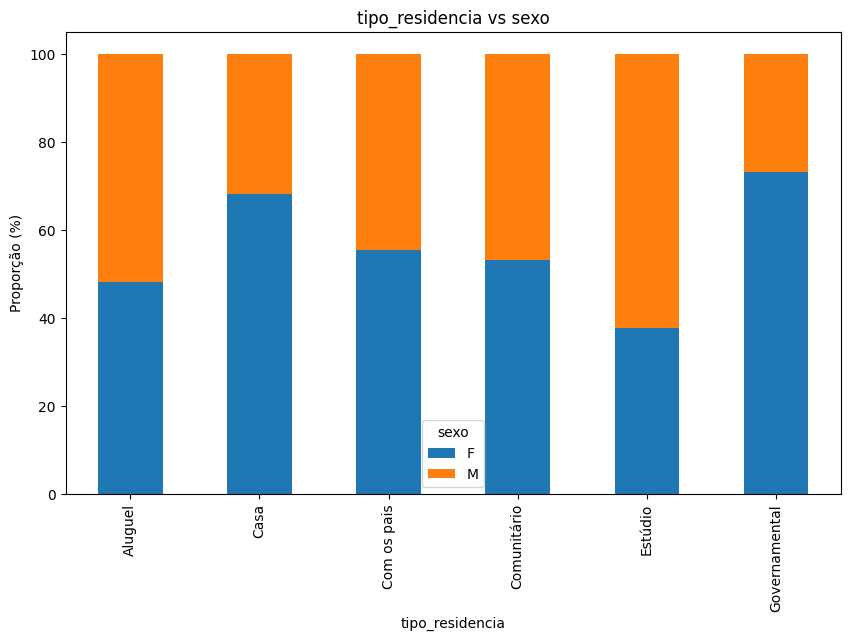


Cruzamento: tipo_residencia vs posse_de_veiculo
posse_de_veiculo          N          S
tipo_residencia                       
Aluguel           58.189197  41.810803
Casa              61.418758  38.581242
Com os pais       56.093524  43.906476
Comunitário       40.000000  60.000000
Estúdio           42.613531  57.386469
Governamental     66.267065  33.732935


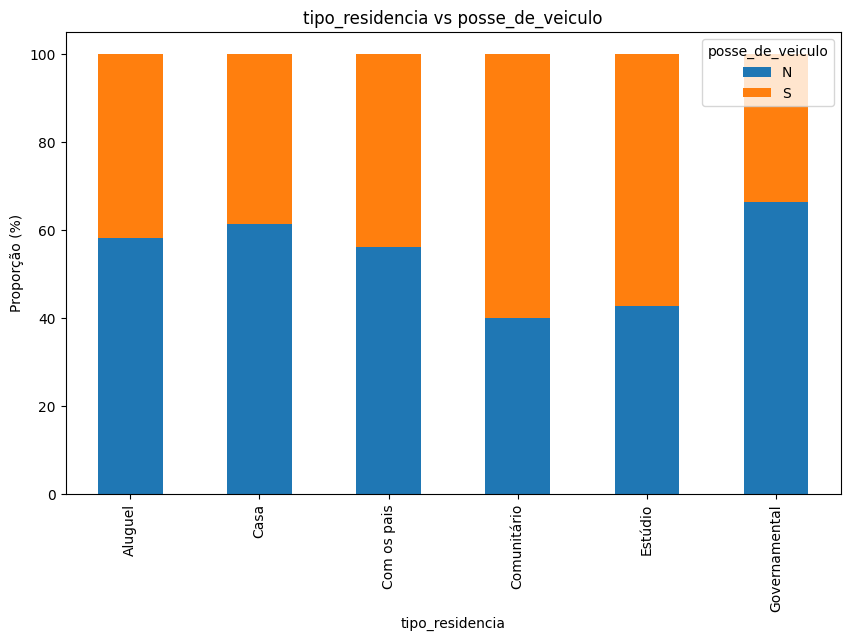


Cruzamento: tipo_residencia vs posse_de_imovel
posse_de_imovel          N          S
tipo_residencia                      
Aluguel          43.018649  56.981351
Casa             29.663470  70.336530
Com os pais      66.914420  33.085580
Comunitário      47.112462  52.887538
Estúdio          53.549583  46.450417
Governamental    64.680034  35.319966


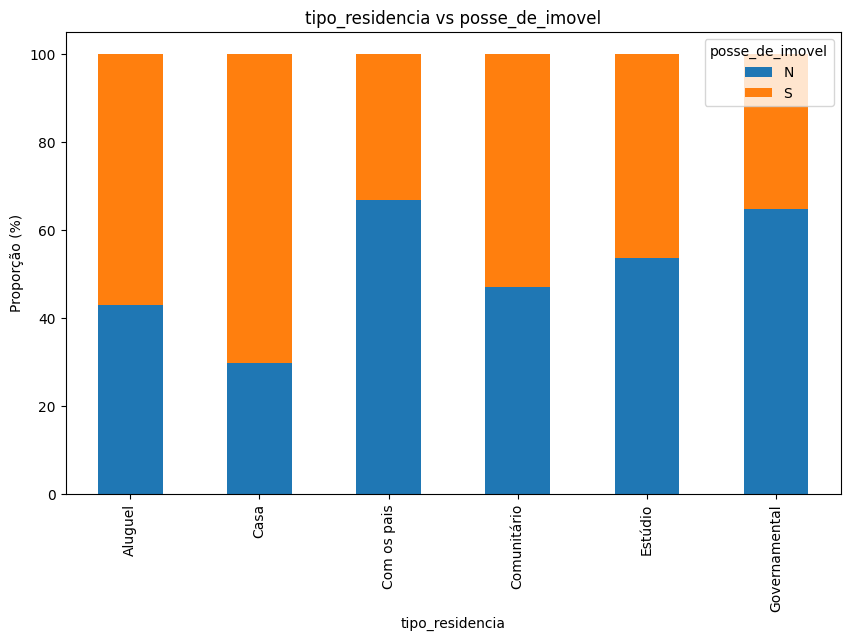


Cruzamento: tipo_residencia vs tipo_renda
tipo_renda       Assalariado  Bolsista  Empresário  Pensionista  \
tipo_residencia                                                   
Aluguel            61.919026  0.000000   24.591748     6.058556   
Casa               50.611158  0.053537   22.946519    17.986220   
Com os pais        63.908281  0.000000   25.610857     0.267814   
Comunitário        77.173252  0.000000    9.331307     0.000000   
Estúdio            38.721038  0.000000   26.858202    11.862836   
Governamental      52.039249  0.000000   22.069113    15.482082   

tipo_renda       Servidor público  
tipo_residencia                    
Aluguel                  7.430670  
Casa                     8.402566  
Com os pais             10.213048  
Comunitário             13.495441  
Estúdio                 22.557924  
Governamental           10.409556  


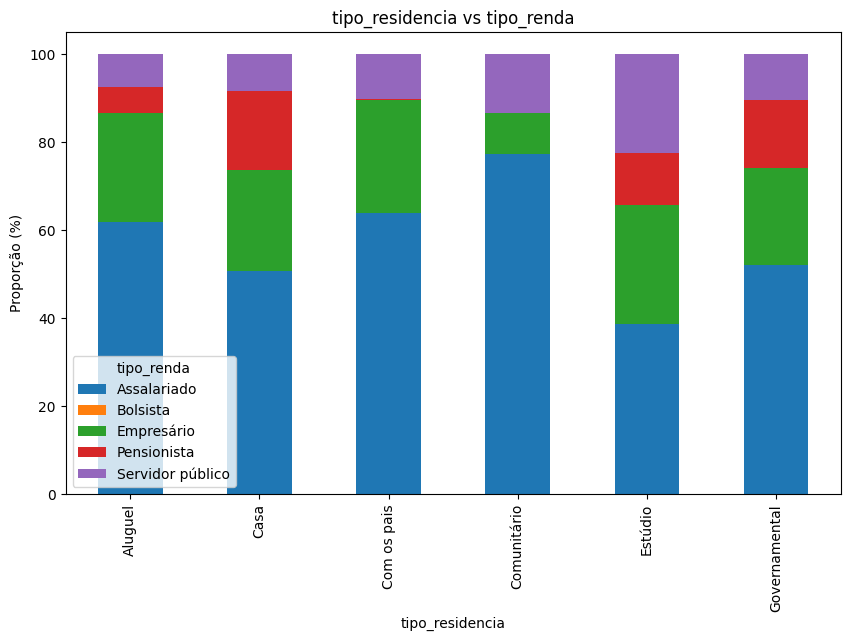


Cruzamento: tipo_residencia vs educacao
educacao         Fundamental      Médio  Pós graduação  Superior completo  \
tipo_residencia                                                             
Aluguel             0.802010  73.060199       0.000000          17.943763   
Casa                1.110050  67.787790       0.120422          27.290321   
Com os pais         1.441382  56.936086       0.000000          32.899013   
Comunitário         6.990881  32.340426       0.000000          50.668693   
Estúdio             0.000000  58.535681       0.000000          37.757183   
Governamental       1.271331  81.241468       0.000000          16.190273   

educacao         Superior incompleto  
tipo_residencia                       
Aluguel                     8.194028  
Casa                        3.691417  
Com os pais                 8.723519  
Comunitário                10.000000  
Estúdio                     3.707136  
Governamental               1.296928  


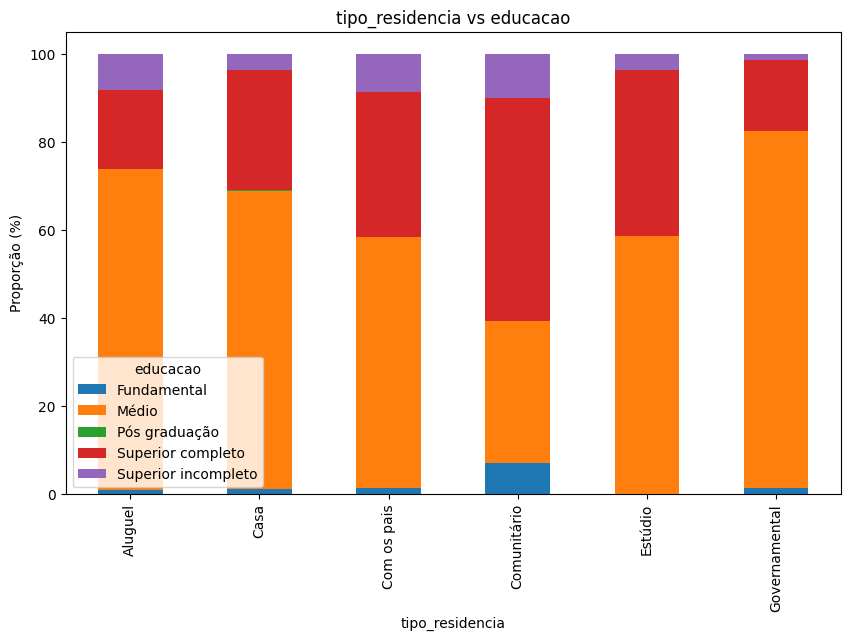


Cruzamento: tipo_residencia vs estado_civil
estado_civil        Casado  Separado   Solteiro      União     Viúvo
tipo_residencia                                                     
Aluguel          63.677650  2.415692  27.384288   5.614069  0.908300
Casa             70.518943  5.649316  11.692971   7.665202  4.473568
Com os pais      64.976529  6.707390  16.962566  11.034545  0.318970
Comunitário      77.993921  3.890578  11.033435   1.367781  5.714286
Estúdio          70.176089  8.433735  10.936052  10.454124  0.000000
Governamental    70.102389  6.040956  14.462457   4.872014  4.522184


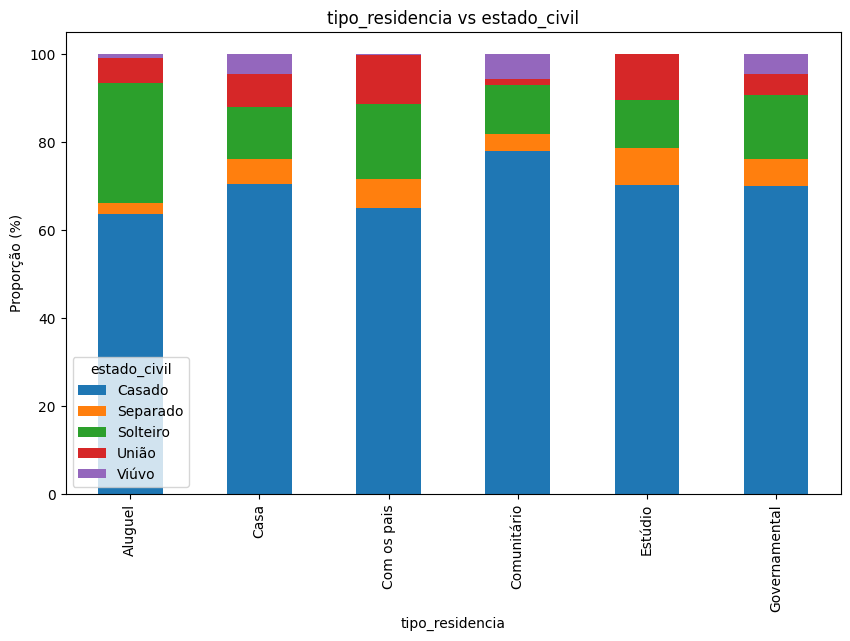


Estatísticas de idade por categoria de sexo:
         count       mean        std   min   25%   50%   75%   max
sexo                                                              
F     504580.0  45.498870  11.194139  22.0  36.0  45.0  55.0  68.0
M     245420.0  40.321612  10.474950  22.0  32.0  39.0  47.0  68.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


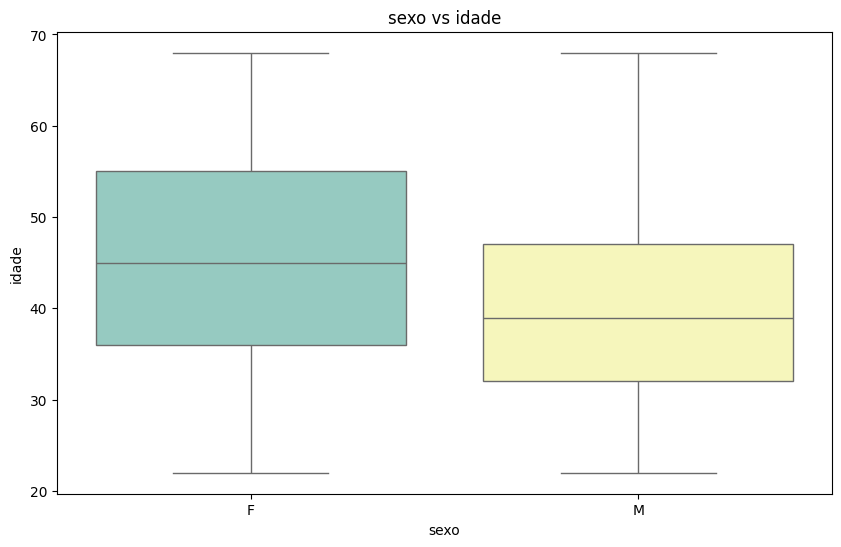


Estatísticas de tempo_emprego por categoria de sexo:
         count      mean       std       min       25%       50%        75%  \
sexo                                                                          
F     396774.0  8.443472  7.288081  0.117808  3.312329  6.515068  11.041096   
M     227269.0  6.535397  5.268084  0.191781  2.690411  5.216438   9.052055   

            max  
sexo             
F     42.906849  
M     40.786301  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


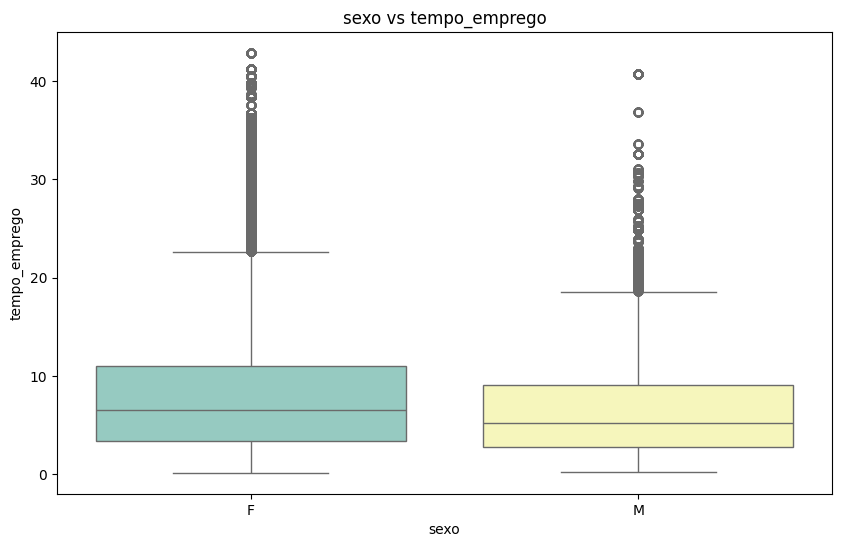


Estatísticas de qt_pessoas_residencia por categoria de sexo:
         count      mean       std  min  25%  50%  75%   max
sexo                                                        
F     504580.0  2.115470  0.864713  1.0  2.0  2.0  2.0   9.0
M     245420.0  2.411201  0.947675  1.0  2.0  2.0  3.0  15.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


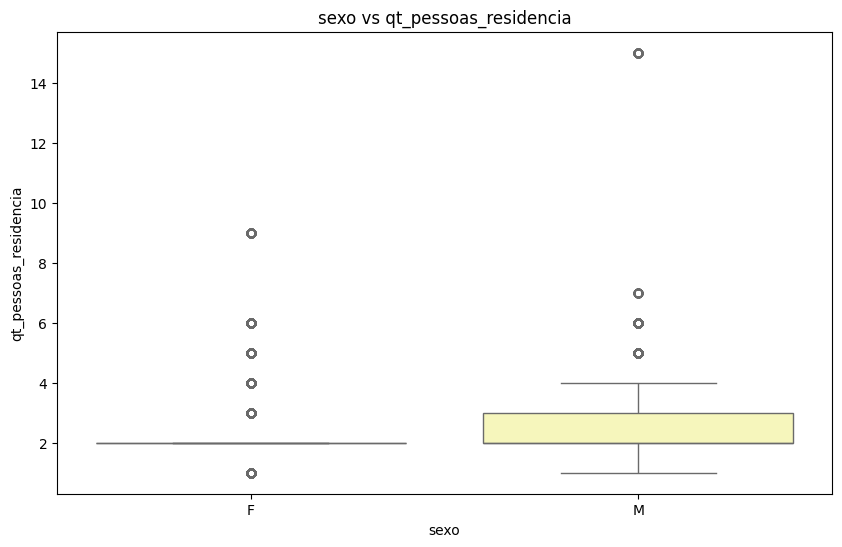


Estatísticas de qtd_filhos por categoria de sexo:
         count      mean       std  min  25%  50%  75%   max
sexo                                                        
F     504580.0  0.373560  0.685245  0.0  0.0  0.0  1.0   7.0
M     245420.0  0.555973  0.826352  0.0  0.0  0.0  1.0  14.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


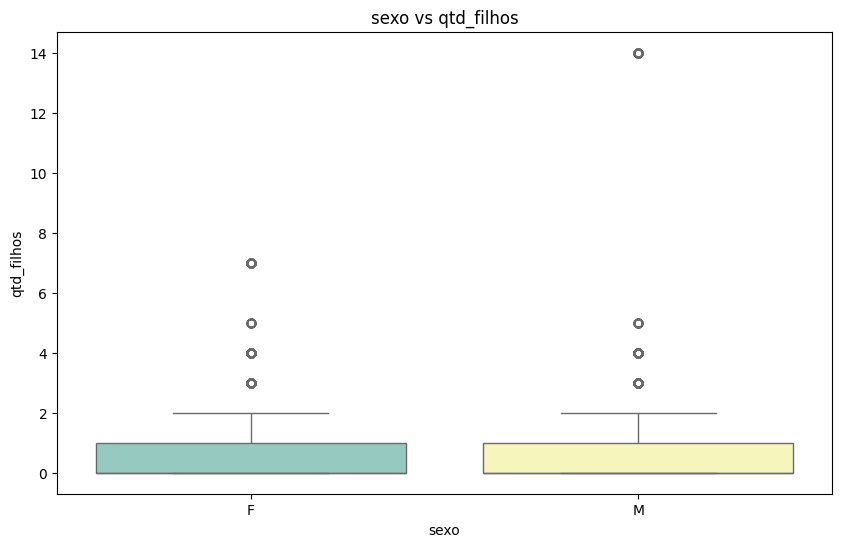


Estatísticas de renda por categoria de sexo:
         count          mean           std     min      25%      50%  \
sexo                                                                   
F     504580.0  27151.873602  94646.057425  107.67  3342.47  7762.28   
M     245420.0  15192.796751  24701.375531  123.69  3740.29  8048.37   

            75%         max  
sexo                         
F     18977.285  4083986.22  
M     17222.140   756920.60  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


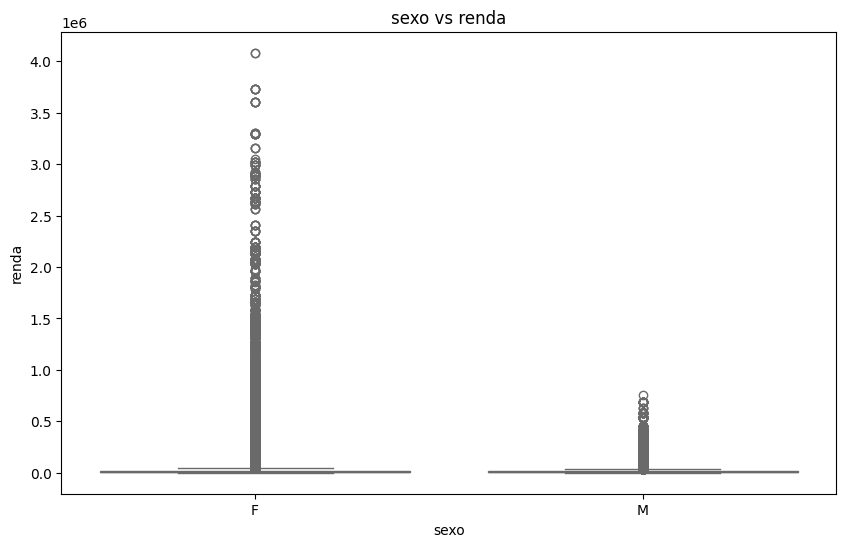


Estatísticas de idade por categoria de posse_de_veiculo:
                     count       mean        std   min   25%   50%   75%   max
posse_de_veiculo                                                              
N                 457954.0  45.327129  11.488412  22.0  36.0  45.0  55.0  68.0
S                 292046.0  41.417482  10.371430  23.0  33.0  40.0  49.0  68.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


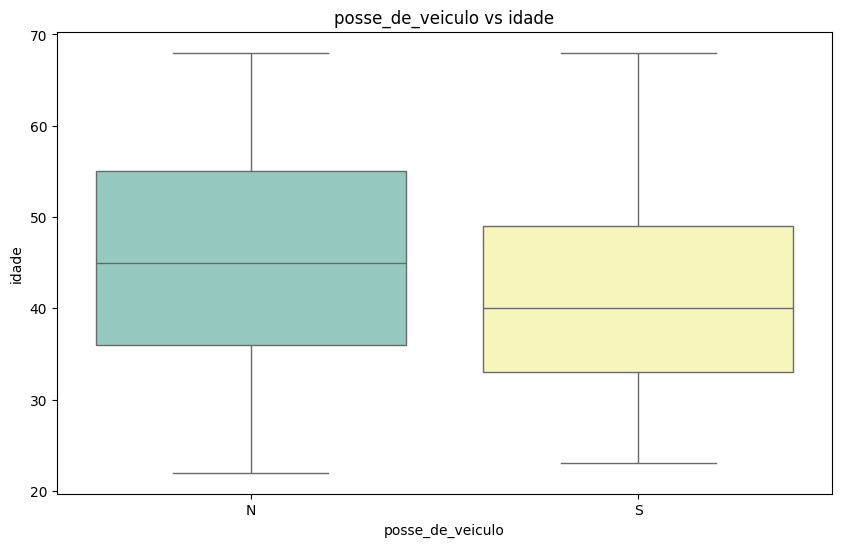


Estatísticas de tempo_emprego por categoria de posse_de_veiculo:
                     count      mean       std       min       25%       50%  \
posse_de_veiculo                                                               
N                 360466.0  8.188326  7.181740  0.117808  3.164384  6.347945   
S                 263577.0  7.147173  5.892431  0.200000  2.936986  5.684932   

                        75%        max  
posse_de_veiculo                        
N                 10.849315  42.906849  
S                  9.589041  41.200000  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


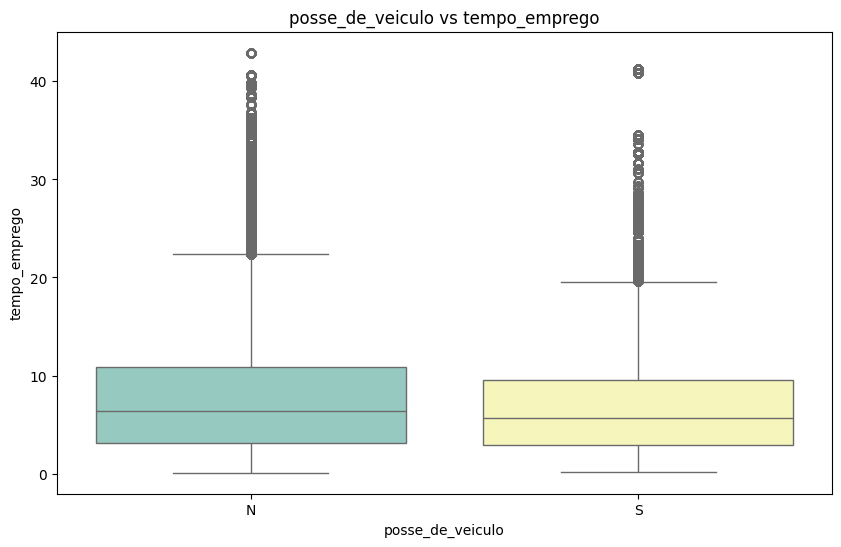


Estatísticas de qt_pessoas_residencia por categoria de posse_de_veiculo:
                     count      mean       std  min  25%  50%  75%   max
posse_de_veiculo                                                        
N                 457954.0  2.094551  0.870483  1.0  2.0  2.0  2.0   9.0
S                 292046.0  2.396790  0.923065  1.0  2.0  2.0  3.0  15.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


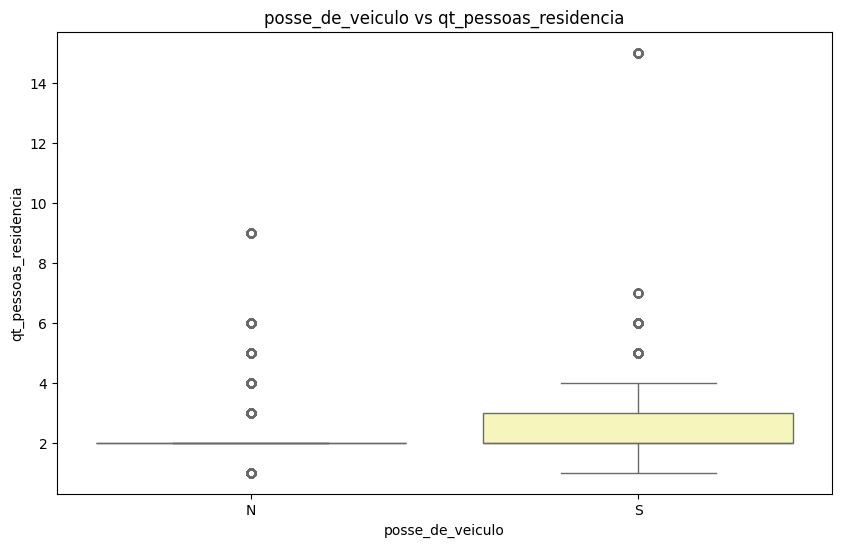


Estatísticas de qtd_filhos por categoria de posse_de_veiculo:
                     count      mean       std  min  25%  50%  75%   max
posse_de_veiculo                                                        
N                 457954.0  0.365941  0.680553  0.0  0.0  0.0  1.0   7.0
S                 292046.0  0.538799  0.812046  0.0  0.0  0.0  1.0  14.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


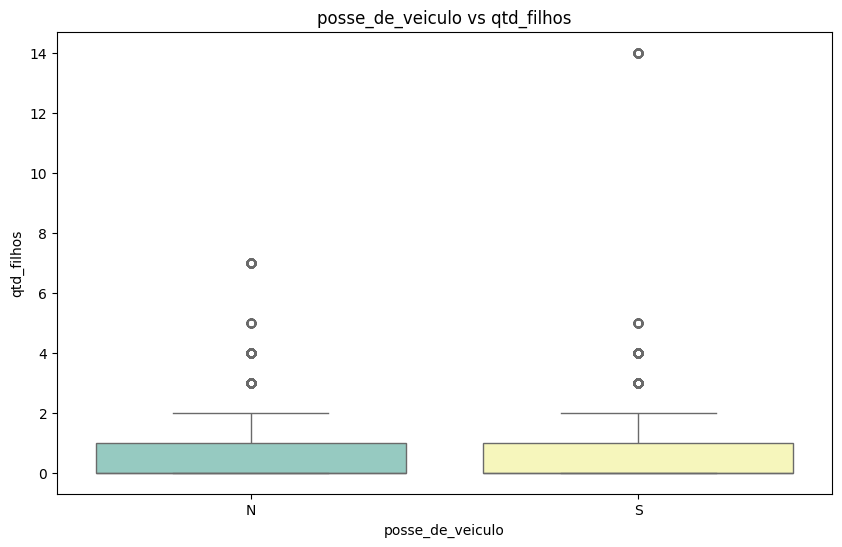


Estatísticas de renda por categoria de posse_de_veiculo:
                     count          mean           std     min      25%  \
posse_de_veiculo                                                          
N                 457954.0  25427.304569  90175.671590  107.67  3411.85   
S                 292046.0  19806.375447  57446.158393  117.12  3564.05   

                      50%         75%         max  
posse_de_veiculo                                   
N                 7802.24  18561.1175  4083986.22  
S                 7949.35  17957.9100  2406262.55  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


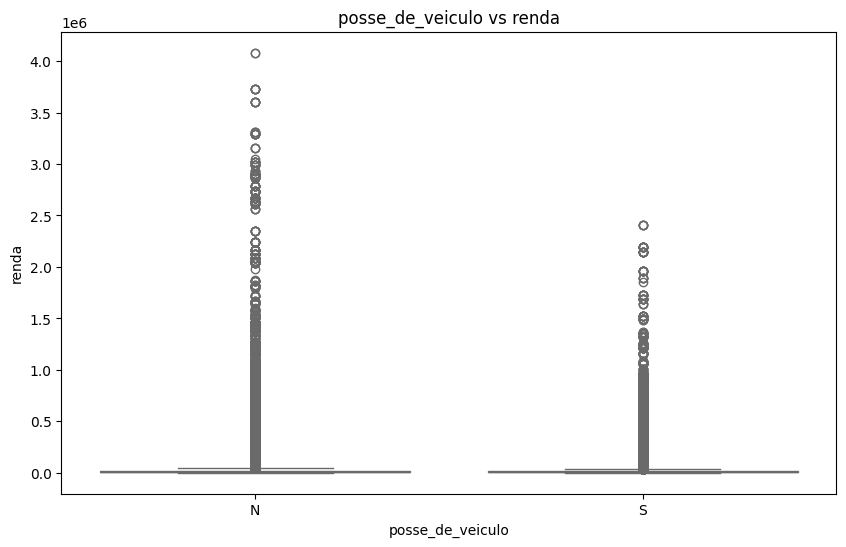


Estatísticas de idade por categoria de posse_de_imovel:
                    count       mean        std   min   25%   50%   75%   max
posse_de_imovel                                                              
N                246308.0  41.686657  10.757616  22.0  33.0  40.0  50.0  68.0
S                503692.0  44.840484  11.310227  22.0  35.0  44.0  54.0  68.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


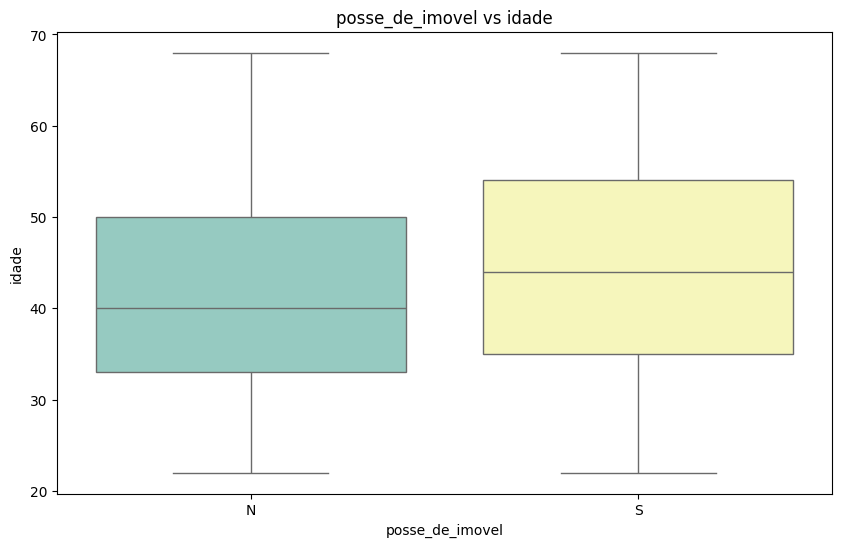


Estatísticas de tempo_emprego por categoria de posse_de_imovel:
                    count      mean       std       min       25%       50%  \
posse_de_imovel                                                               
N                217889.0  7.700882  6.540776  0.117808  3.101370  6.060274   
S                406154.0  7.774159  6.764702  0.178082  3.046575  6.021918   

                       75%        max  
posse_de_imovel                        
N                10.375342  40.786301  
S                10.109589  42.906849  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


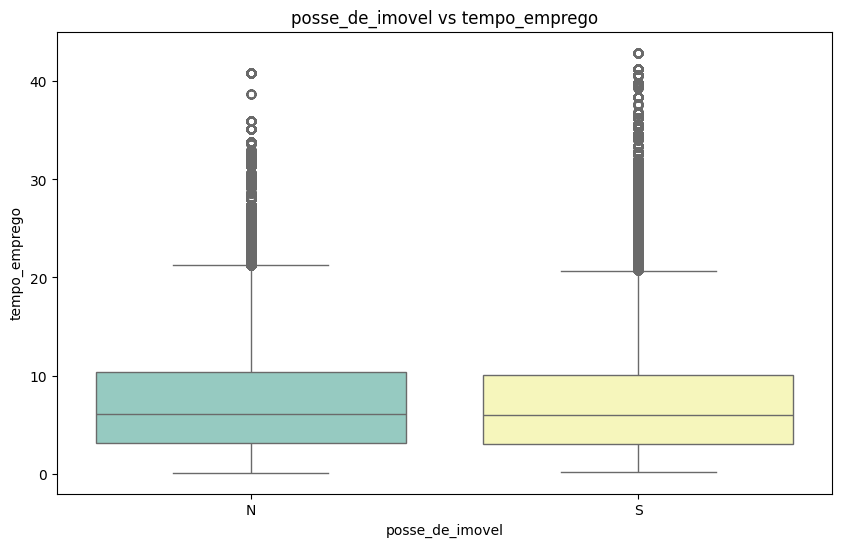


Estatísticas de qt_pessoas_residencia por categoria de posse_de_imovel:
                    count      mean       std  min  25%  50%  75%   max
posse_de_imovel                                                        
N                246308.0  2.233033  0.896261  1.0  2.0  2.0  3.0   9.0
S                503692.0  2.202074  0.906740  1.0  2.0  2.0  3.0  15.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


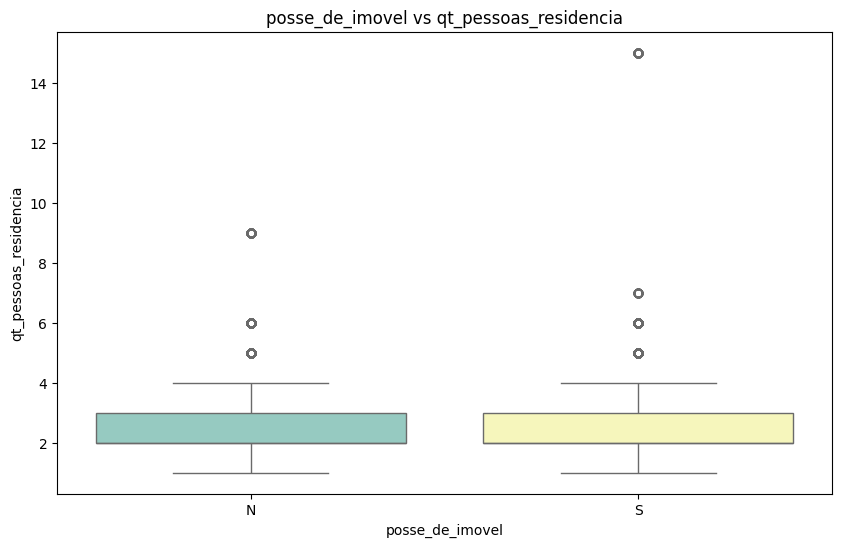


Estatísticas de qtd_filhos por categoria de posse_de_imovel:
                    count      mean       std  min  25%  50%  75%   max
posse_de_imovel                                                        
N                246308.0  0.446502  0.737302  0.0  0.0  0.0  1.0   7.0
S                503692.0  0.426771  0.740307  0.0  0.0  0.0  1.0  14.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


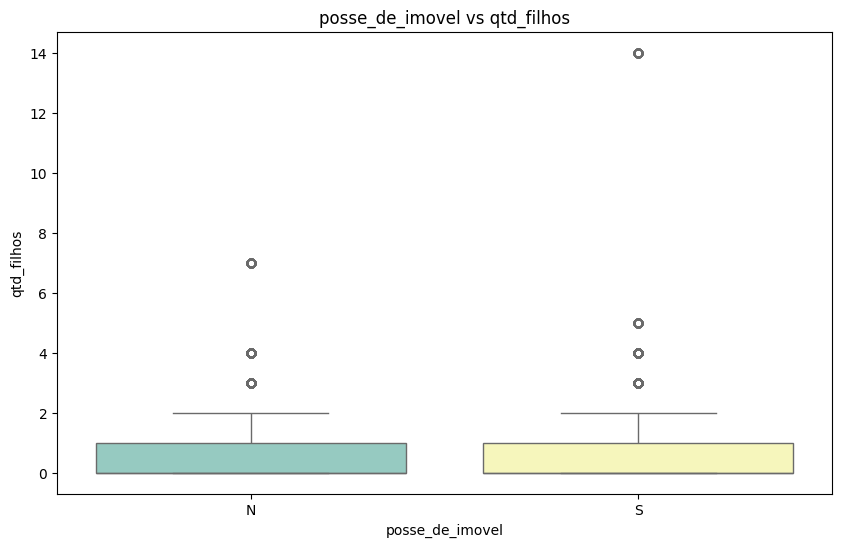


Estatísticas de renda por categoria de posse_de_imovel:
                    count          mean           std     min      25%  \
posse_de_imovel                                                          
N                246308.0  19892.129984  60423.917579  113.36  3028.78   
S                503692.0  24874.958920  86742.796249  107.67  3715.60   

                      50%       75%         max  
posse_de_imovel                                  
N                6894.955  16173.83  2860400.84  
S                8373.460  19367.44  4083986.22  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


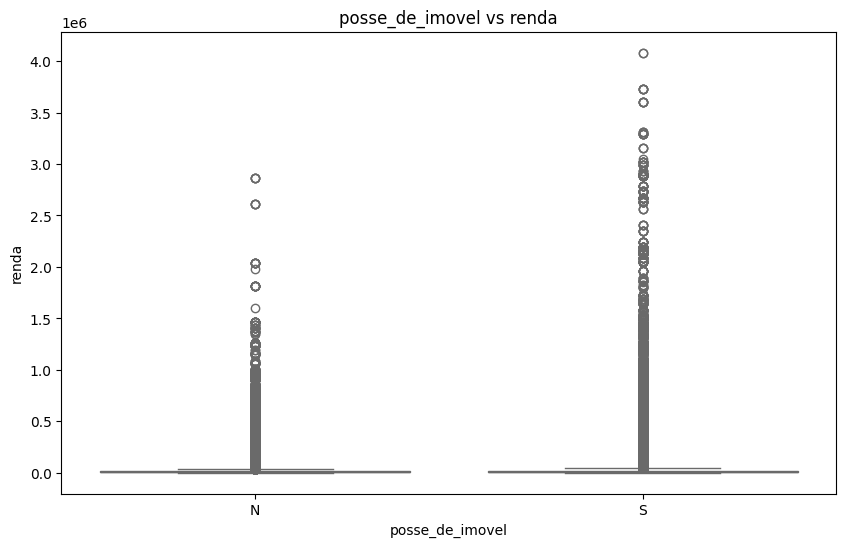


Estatísticas de idade por categoria de tipo_renda:
                     count       mean       std   min   25%   50%   75%   max
tipo_renda                                                                   
Assalariado       385740.0  40.850075  9.384178  22.0  33.0  40.0  48.0  66.0
Bolsista             361.0  51.000000  0.000000  51.0  51.0  51.0  51.0  51.0
Empresário        172712.0  39.986457  9.135298  22.0  32.0  40.0  47.0  67.0
Pensionista       126265.0  59.268934  5.215912  26.0  57.0  60.0  63.0  68.0
Servidor público   64922.0  41.401959  9.843407  23.0  33.0  41.0  49.0  66.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


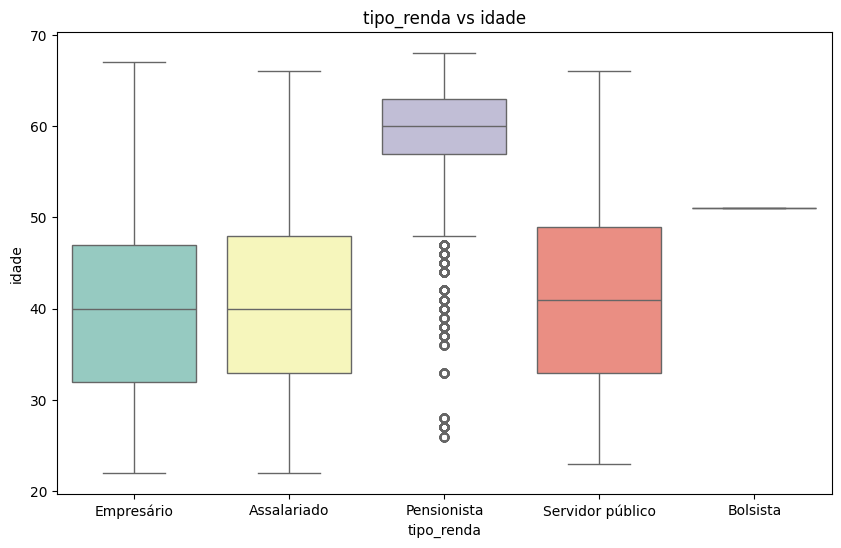


Estatísticas de tempo_emprego por categoria de tipo_renda:
                     count       mean           std        min        25%  \
tipo_renda                                                                  
Assalariado       385740.0   7.768052  6.771539e+00   0.117808   3.016438   
Bolsista             361.0  10.695890  3.557645e-15  10.695890  10.695890   
Empresário        172712.0   6.651401  5.636926e+00   0.200000   2.679452   
Pensionista          308.0   6.928927  4.594275e+00   1.605479   1.698630   
Servidor público   64922.0  10.539157  7.858765e+00   0.241096   4.852055   

                        50%        75%        max  
tipo_renda                                         
Assalariado        5.964384  10.183562  40.786301  
Bolsista          10.695890  10.695890  10.695890  
Empresário         5.386301   8.772603  42.906849  
Pensionista        6.049315  10.082192  15.126027  
Servidor público   8.893151  14.389041  41.200000  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


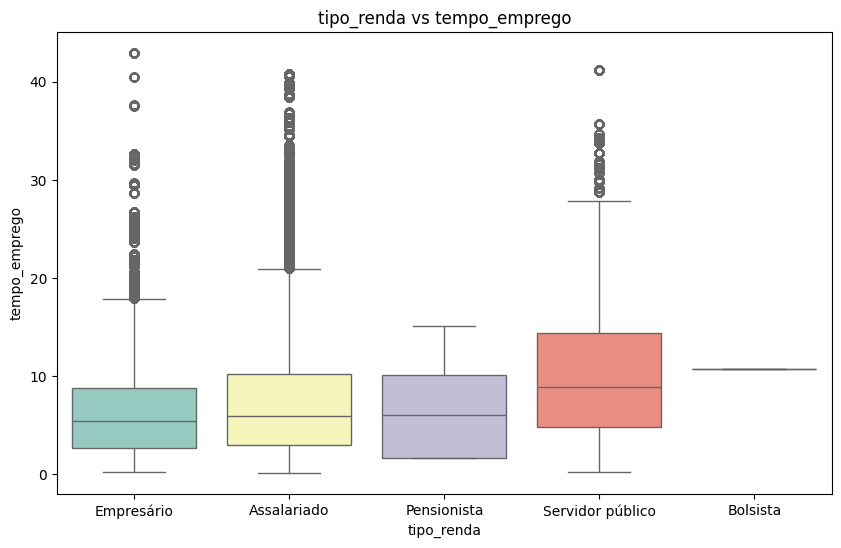


Estatísticas de qt_pessoas_residencia por categoria de tipo_renda:
                     count      mean       std  min  25%  50%  75%   max
tipo_renda                                                              
Assalariado       385740.0  2.325201  0.951232  1.0  2.0  2.0  3.0  15.0
Bolsista             361.0  2.000000  0.000000  2.0  2.0  2.0  2.0   2.0
Empresário        172712.0  2.242751  0.883287  1.0  2.0  2.0  3.0   6.0
Pensionista       126265.0  1.748901  0.531942  1.0  1.0  2.0  2.0   4.0
Servidor público   64922.0  2.362235  0.952988  1.0  2.0  2.0  3.0   6.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


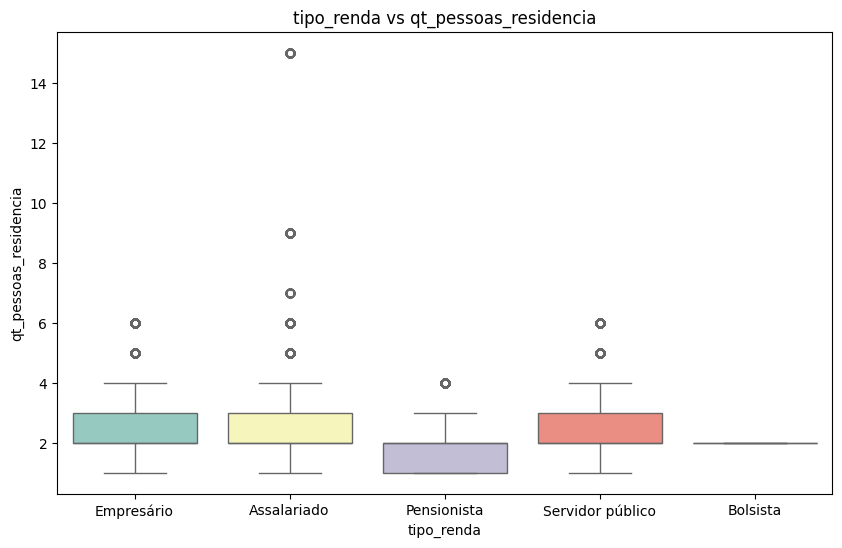


Estatísticas de qtd_filhos por categoria de tipo_renda:
                     count      mean       std  min  25%  50%  75%   max
tipo_renda                                                              
Assalariado       385740.0  0.527498  0.804489  0.0  0.0  0.0  1.0  14.0
Bolsista             361.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Empresário        172712.0  0.463540  0.716805  0.0  0.0  0.0  1.0   4.0
Pensionista       126265.0  0.041555  0.239309  0.0  0.0  0.0  0.0   3.0
Servidor público   64922.0  0.556899  0.788567  0.0  0.0  0.0  1.0   4.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


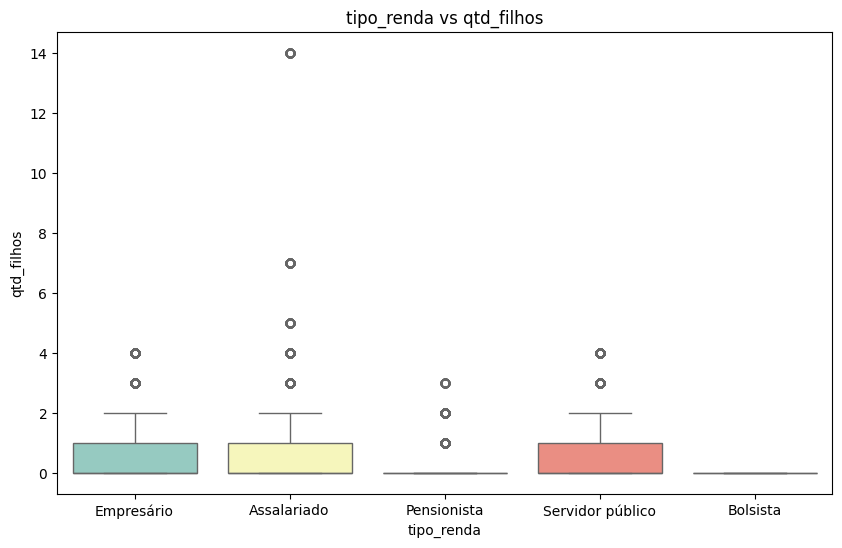


Estatísticas de renda por categoria de tipo_renda:
                     count          mean            std      min      25%  \
tipo_renda                                                                  
Assalariado       385740.0  24687.396651   87385.647650   113.36  3332.74   
Bolsista             361.0  22188.600055   27502.504563  1728.29  5896.68   
Empresário        172712.0  21414.631015   60575.566055   107.67  3562.87   
Pensionista       126265.0  10479.306200   11645.399809   193.97  3267.27   
Servidor público   64922.0  44303.144432  126922.071367   197.96  4971.42   

                       50%       75%         max  
tipo_renda                                        
Assalariado        7733.25  18766.18  4083986.22  
Bolsista          12522.08  24259.82   135247.09  
Empresário         8071.79  18595.82  2893650.89  
Pensionista        6598.15  13317.96   188500.90  
Servidor público  12264.42  33070.71  2884373.30  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


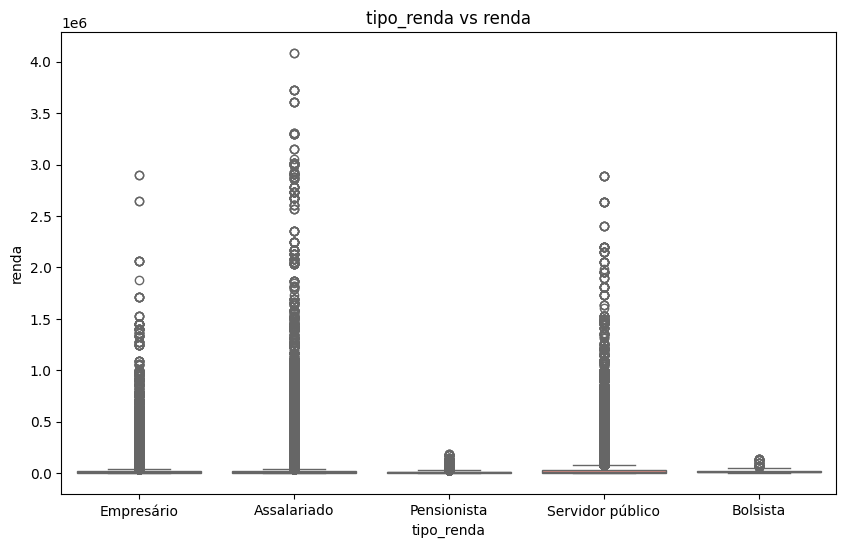


Estatísticas de idade por categoria de educacao:
                        count       mean        std   min   25%   50%   75%  \
educacao                                                                      
Fundamental            8575.0  48.528980  13.441042  26.0  36.0  52.0  61.0   
Médio                506836.0  45.260591  10.945420  22.0  37.0  45.0  54.0   
Pós graduação           812.0  41.476601  11.986663  33.0  33.0  34.0  58.0   
Superior completo    204306.0  41.214252  11.045492  22.0  32.0  39.0  49.0   
Superior incompleto   29471.0  35.415120   9.312403  22.0  29.0  33.0  41.0   

                      max  
educacao                   
Fundamental          68.0  
Médio                68.0  
Pós graduação        61.0  
Superior completo    68.0  
Superior incompleto  66.0  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


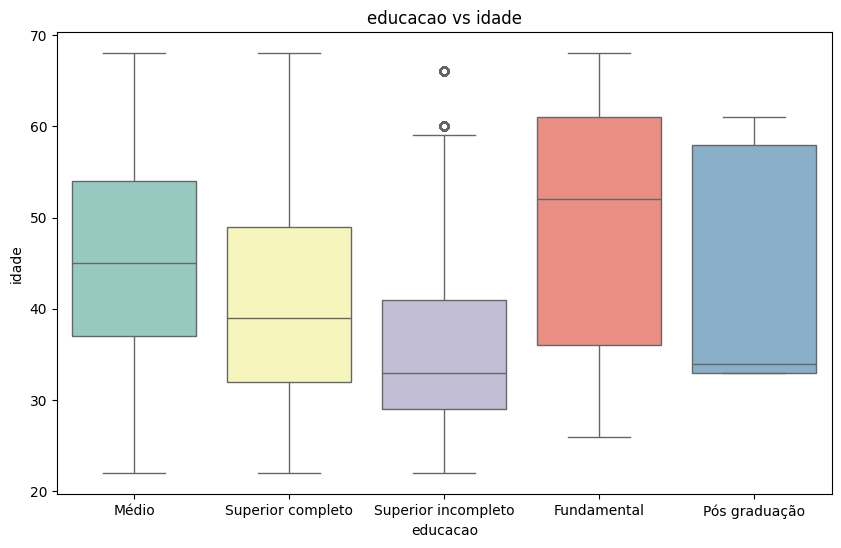


Estatísticas de tempo_emprego por categoria de educacao:
                        count      mean       std       min       25%  \
educacao                                                                
Fundamental            4908.0  6.005603  4.686679  0.117808  2.221918   
Médio                406901.0  7.980896  6.872524  0.191781  3.098630   
Pós graduação           812.0  4.526287  4.711681  0.534247  2.682192   
Superior completo    183239.0  7.495275  6.397751  0.200000  3.104110   
Superior incompleto   28183.0  6.437614  5.831813  0.178082  2.446575   

                          50%        75%        max  
educacao                                             
Fundamental          6.002740   7.104110  29.572603  
Médio                6.216438  10.435616  42.906849  
Pós graduação        2.682192   7.586301  20.704110  
Superior completo    5.978082  10.035616  41.200000  
Superior incompleto  5.197260   8.186301  32.750685  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


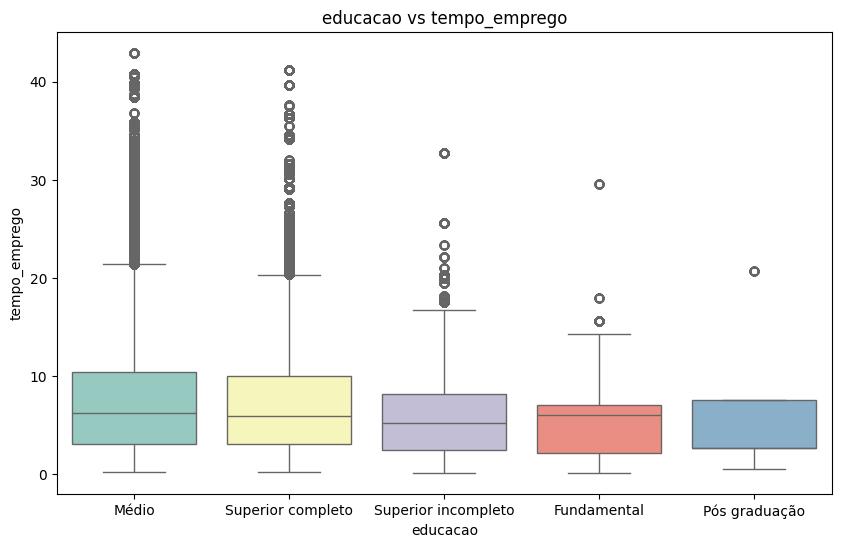


Estatísticas de qt_pessoas_residencia por categoria de educacao:
                        count      mean       std  min  25%  50%  75%   max
educacao                                                                   
Fundamental            8575.0  2.088513  0.732769  1.0  2.0  2.0  2.0   4.0
Médio                506836.0  2.183803  0.892671  1.0  2.0  2.0  3.0  15.0
Pós graduação           812.0  2.501232  0.500307  2.0  2.0  3.0  3.0   3.0
Superior completo    204306.0  2.273844  0.922001  1.0  2.0  2.0  3.0   6.0
Superior incompleto   29471.0  2.302297  0.977380  1.0  2.0  2.0  3.0   6.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


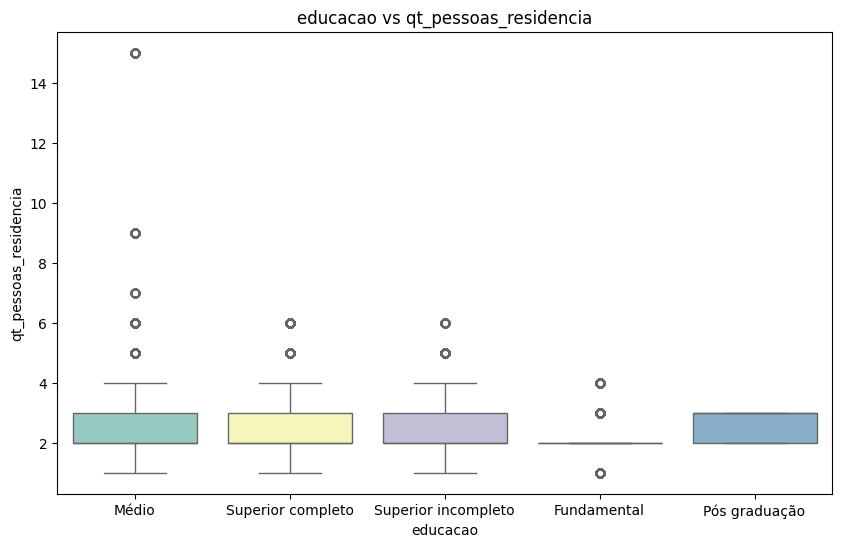


Estatísticas de qtd_filhos por categoria de educacao:
                        count      mean       std  min  25%  50%  75%   max
educacao                                                                   
Fundamental            8575.0  0.272070  0.593120  0.0  0.0  0.0  0.0   2.0
Médio                506836.0  0.401457  0.737027  0.0  0.0  0.0  1.0  14.0
Pós graduação           812.0  0.727833  0.445350  0.0  0.0  1.0  1.0   1.0
Superior completo    204306.0  0.501821  0.740662  0.0  0.0  0.0  1.0   4.0
Superior incompleto   29471.0  0.543449  0.766496  0.0  0.0  0.0  1.0   4.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


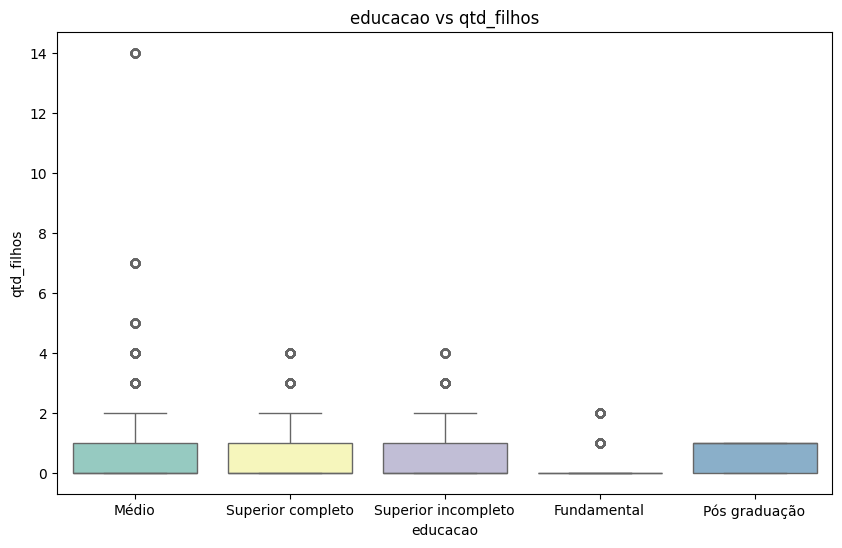


Estatísticas de renda por categoria de educacao:
                        count          mean           std     min        25%  \
educacao                                                                       
Fundamental            8575.0  12081.212859  17355.443801  221.70  3059.6500   
Médio                506836.0  22709.092063  77037.026771  107.67  3361.7200   
Pós graduação           812.0  13656.823485  18908.380128  383.52  3409.4500   
Superior completo    204306.0  25778.131743  88859.828713  117.12  3830.3475   
Superior incompleto   29471.0  18248.802235  47318.631916  176.64  3244.4900   

                         50%       75%         max  
educacao                                            
Fundamental          6423.51  14624.19   182648.89  
Médio                7628.91  17804.69  4083986.22  
Pós graduação        7199.37  15001.20   133820.41  
Superior completo    8686.81  20189.11  3607412.81  
Superior incompleto  7128.23  16024.11   897431.89  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


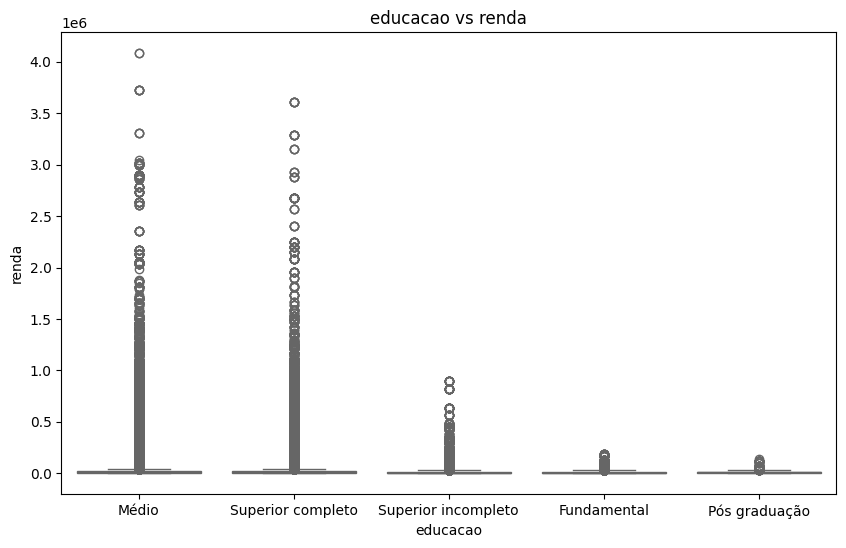


Estatísticas de idade por categoria de estado_civil:
                 count       mean        std   min   25%   50%   75%   max
estado_civil                                                              
Casado        526472.0  43.486856  10.914390  22.0  34.0  42.0  52.0  68.0
Separado       42571.0  46.204153   9.658664  22.0  39.0  46.0  53.0  68.0
Solteiro       91659.0  41.782531  12.313616  22.0  31.0  41.0  51.0  68.0
União          57685.0  41.582179  10.454033  22.0  34.0  40.0  48.0  68.0
Viúvo          31613.0  55.786164   8.337904  28.0  52.0  57.0  62.0  68.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


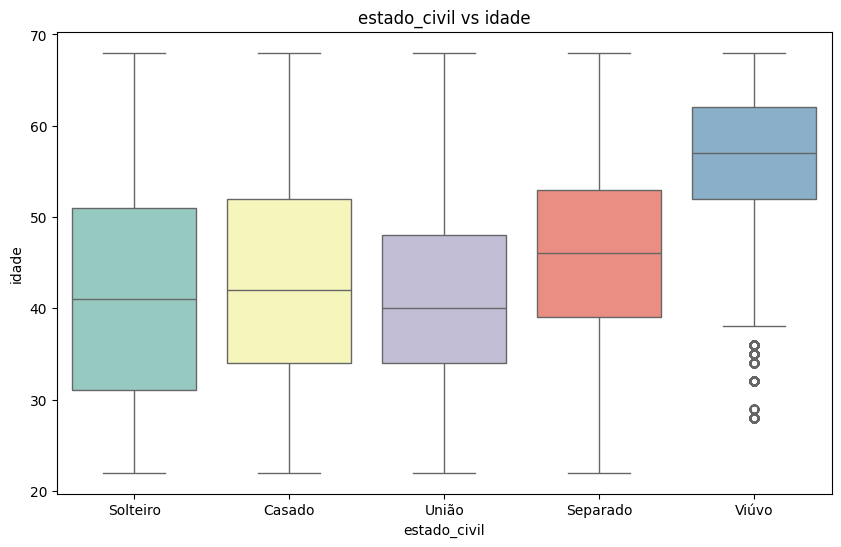


Estatísticas de tempo_emprego por categoria de estado_civil:
                 count      mean       std       min       25%       50%  \
estado_civil                                                               
Casado        445154.0  7.769522  6.471314  0.117808  3.189041  6.271233   
Separado       36244.0  8.303183  7.603398  0.216438  2.794521  5.630137   
Solteiro       78034.0  7.384581  7.349198  0.254795  2.539726  5.282192   
União          49981.0  7.284928  6.312521  0.241096  2.243836  5.520548   
Viúvo          14630.0  9.262647  7.838827  0.389041  3.684932  6.934247   

                    75%        max  
estado_civil                        
Casado        10.301370  42.906849  
Separado      11.183562  35.476712  
Solteiro       8.958904  41.200000  
União          9.852055  29.646575  
Viúvo         13.780822  39.282192  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


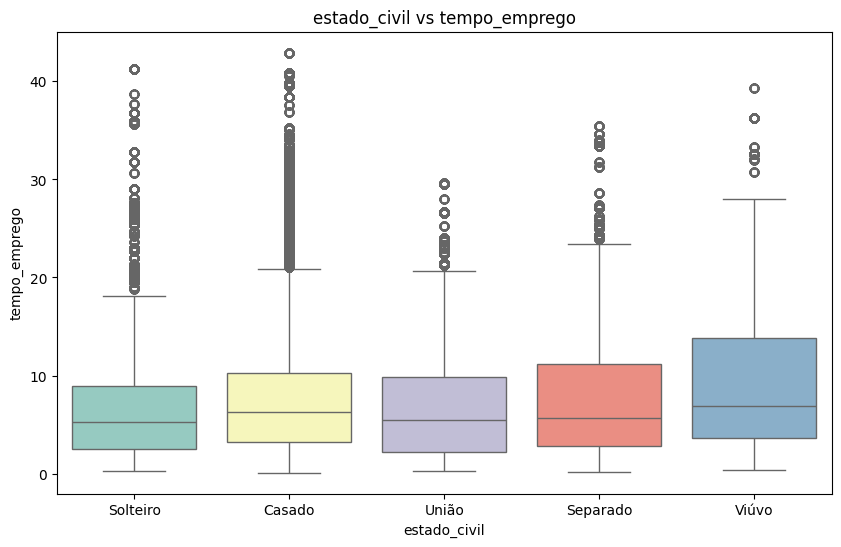


Estatísticas de qt_pessoas_residencia por categoria de estado_civil:
                 count      mean       std  min  25%  50%  75%   max
estado_civil                                                        
Casado        526472.0  2.502296  0.780804  1.0  2.0  2.0  3.0   9.0
Separado       42571.0  1.378732  0.838563  1.0  1.0  1.0  2.0  15.0
Solteiro       91659.0  1.189278  0.461331  1.0  1.0  1.0  1.0   4.0
União          57685.0  2.429574  0.665988  1.0  2.0  2.0  3.0   5.0
Viúvo          31613.0  1.073609  0.289407  1.0  1.0  1.0  1.0   4.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


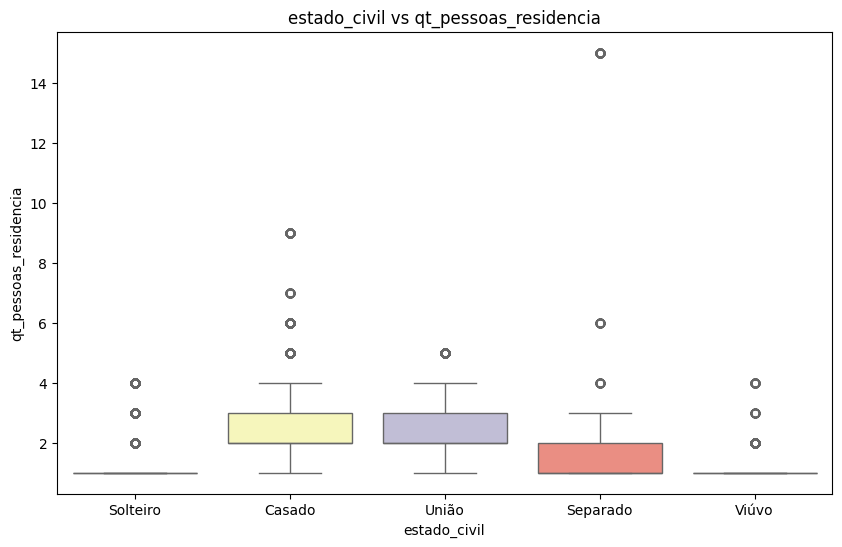


Estatísticas de qtd_filhos por categoria de estado_civil:
                 count      mean       std  min  25%  50%  75%   max
estado_civil                                                        
Casado        526472.0  0.503155  0.780594  0.0  0.0  0.0  1.0   7.0
Separado       42571.0  0.378732  0.838563  0.0  0.0  0.0  1.0  14.0
Solteiro       91659.0  0.182164  0.450250  0.0  0.0  0.0  0.0   3.0
União          57685.0  0.431551  0.664709  0.0  0.0  0.0  1.0   3.0
Viúvo          31613.0  0.073609  0.289407  0.0  0.0  0.0  0.0   3.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


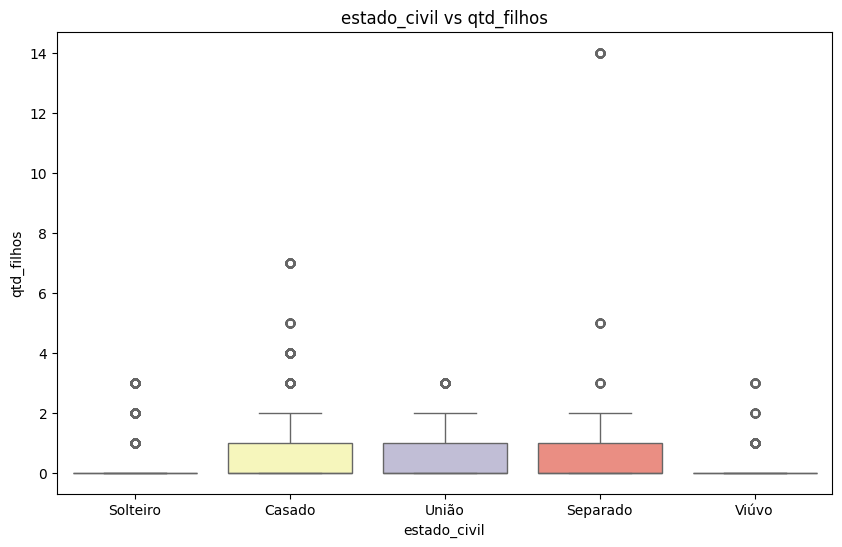


Estatísticas de renda por categoria de estado_civil:
                 count          mean            std     min       25%  \
estado_civil                                                            
Casado        526472.0  21976.634257   70104.031496  107.67  3531.655   
Separado       42571.0  27606.468905   83472.266863  151.93  3347.540   
Solteiro       91659.0  28689.494088  121058.326748  109.21  3297.580   
União          57685.0  22063.372512   60004.149770  193.97  3267.230   
Viúvo          31613.0  24711.827418   89611.199329  245.67  3551.820   

                  50%        75%         max  
estado_civil                                  
Casado        7976.15  18447.805  4083986.22  
Separado      7779.72  19391.560  1983317.93  
Solteiro      7481.30  17612.590  3607412.81  
União         7453.62  17752.470  1362913.96  
Viúvo         7756.74  17688.970  2993543.70  


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


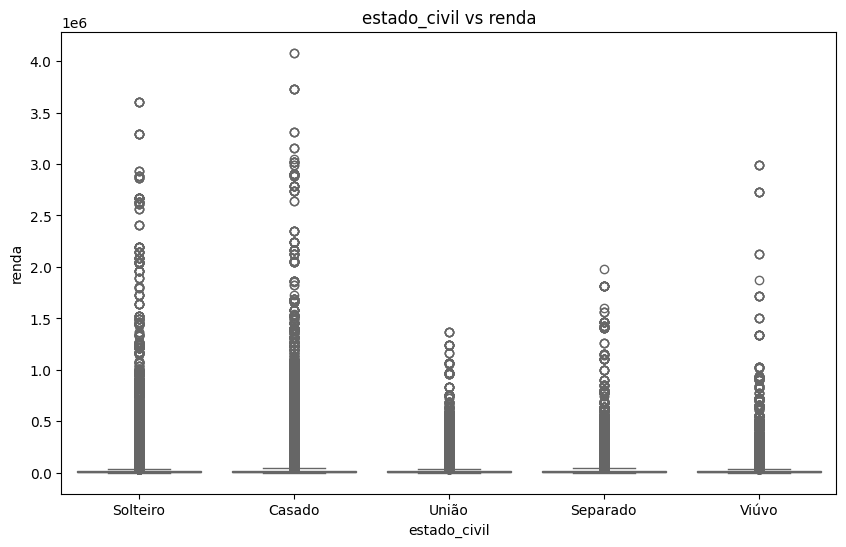


Estatísticas de idade por categoria de tipo_residencia:
                    count       mean        std   min   25%   50%   75%   max
tipo_residencia                                                              
Aluguel           10349.0  37.413277   8.422063  22.0  30.0  37.0  43.0  61.0
Casa             674294.0  44.389544  11.223276  22.0  35.0  44.0  54.0  68.0
Com os pais       33232.0  34.050885   7.353997  22.0  28.0  32.0  38.0  60.0
Comunitário        3290.0  40.582371   9.281028  22.0  35.0  38.0  49.0  60.0
Estúdio            5395.0  42.659129   9.260056  25.0  36.0  40.0  50.0  68.0
Governamental     23440.0  44.347952  10.341938  23.0  36.0  45.0  52.0  65.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


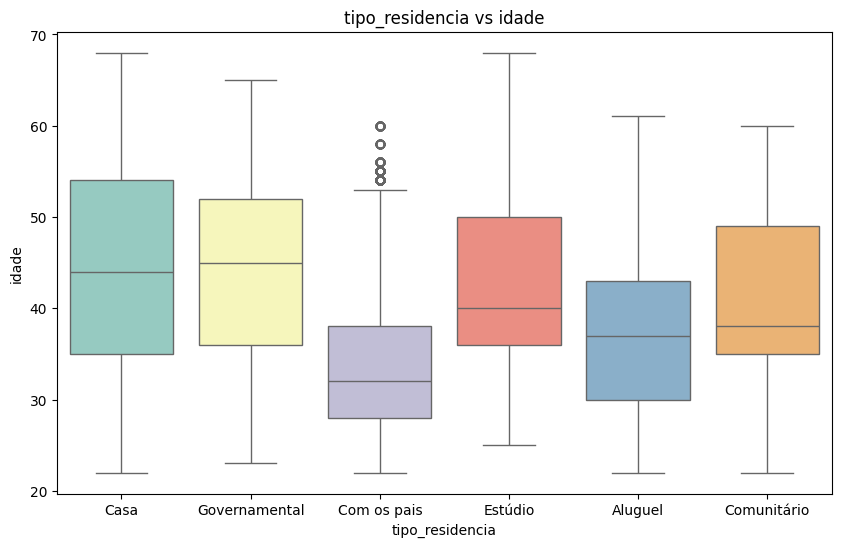


Estatísticas de tempo_emprego por categoria de tipo_residencia:
                    count      mean       std       min       25%       50%  \
tipo_residencia                                                               
Aluguel            9722.0  6.103446  4.595769  0.117808  3.345205  4.597260   
Casa             553322.0  7.881349  6.769735  0.200000  3.117808  6.164384   
Com os pais       33143.0  5.666995  4.874282  0.254795  1.906849  4.424658   
Comunitário        3290.0  5.342582  5.625849  0.802740  1.194521  3.441096   
Estúdio            4755.0  8.769143  5.595154  2.301370  4.635616  7.800000   
Governamental     19811.0  8.484483  7.417943  0.178082  2.679452  6.684932   

                       75%        max  
tipo_residencia                        
Aluguel           8.860274  24.800000  
Casa             10.424658  42.906849  
Com os pais       7.745205  25.652055  
Comunitário       6.263014  23.936986  
Estúdio          11.202740  38.704110  
Governamental    12.43

C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


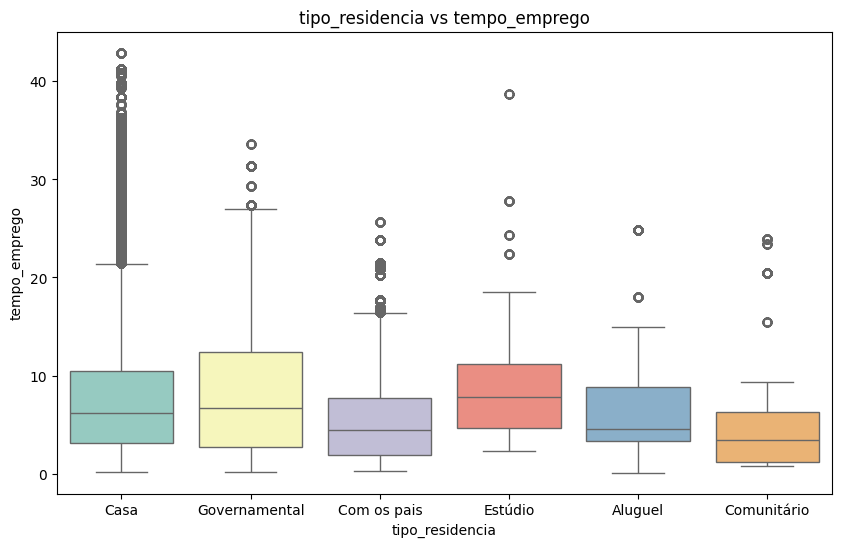


Estatísticas de qt_pessoas_residencia por categoria de tipo_residencia:
                    count      mean       std  min  25%  50%  75%   max
tipo_residencia                                                        
Aluguel           10349.0  2.134216  0.882472  1.0  1.0  2.0  3.0   4.0
Casa             674294.0  2.207589  0.903471  1.0  2.0  2.0  3.0  15.0
Com os pais       33232.0  2.315930  0.955765  1.0  2.0  2.0  3.0   5.0
Comunitário        3290.0  2.244985  1.098181  1.0  2.0  2.0  2.0   7.0
Estúdio            5395.0  2.473401  0.816375  1.0  2.0  2.0  3.0   5.0
Governamental     23440.0  2.168814  0.797598  1.0  2.0  2.0  3.0   5.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


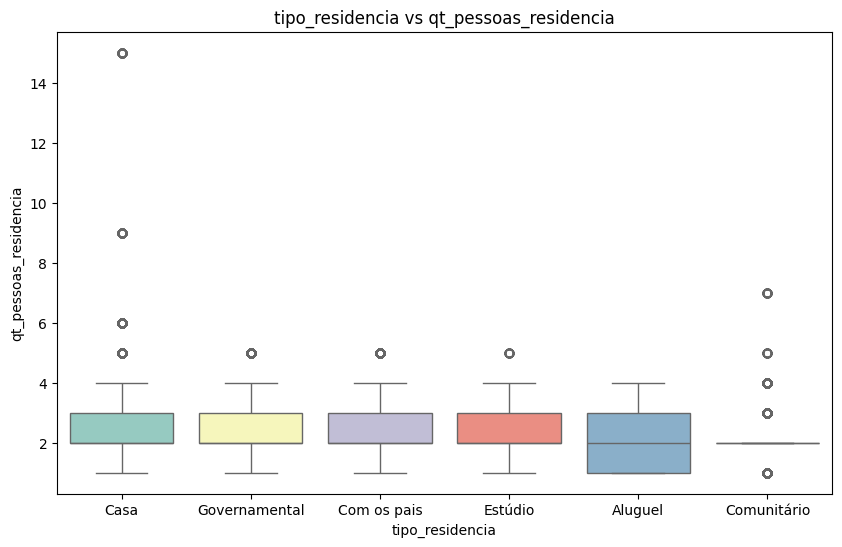


Estatísticas de qtd_filhos por categoria de tipo_residencia:
                    count      mean       std  min  25%  50%  75%   max
tipo_residencia                                                        
Aluguel           10349.0  0.441299  0.631568  0.0  0.0  0.0  1.0   2.0
Casa             674294.0  0.425745  0.740614  0.0  0.0  0.0  1.0  14.0
Com os pais       33232.0  0.555820  0.755995  0.0  0.0  0.0  1.0   3.0
Comunitário        3290.0  0.451368  0.937824  0.0  0.0  0.0  0.0   5.0
Estúdio            5395.0  0.667099  0.718693  0.0  0.0  1.0  1.0   3.0
Governamental     23440.0  0.415486  0.669771  0.0  0.0  0.0  1.0   3.0


C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


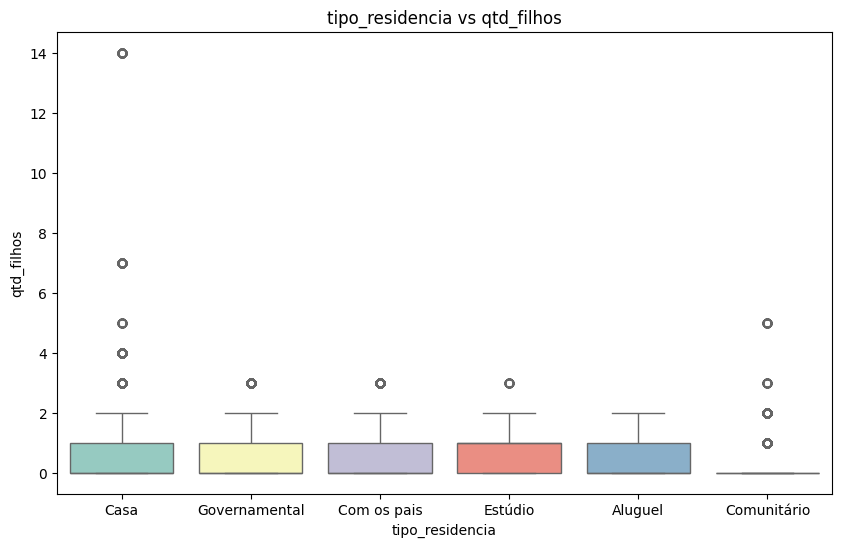


Estatísticas de renda por categoria de tipo_residencia:
                    count          mean           std     min        25%  \
tipo_residencia                                                            
Aluguel           10349.0  15139.273320  28439.759162  193.82  3059.9500   
Casa             674294.0  23789.690300  81875.008137  107.67  3519.8825   
Com os pais       33232.0  13595.573411  28737.127942  172.09  2805.1325   
Comunitário        3290.0  17967.991459  54980.399528  281.87  2728.5200   
Estúdio            5395.0  20930.099811  43881.923751  136.16  4551.9600   
Governamental     23440.0  25902.137946  69365.497003  183.50  3242.3700   

                     50%       75%         max  
tipo_residencia                                 
Aluguel          7139.16  15999.35   400863.97  
Casa             7969.15  18563.15  4083986.22  
Com os pais      6123.57  13598.78   525248.75  
Comunitário      6420.18  13404.06   768603.47  
Estúdio          9561.65  22361.09  1001

C:\Users\mardo\AppData\Local\Temp\ipykernel_11944\4096944841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")


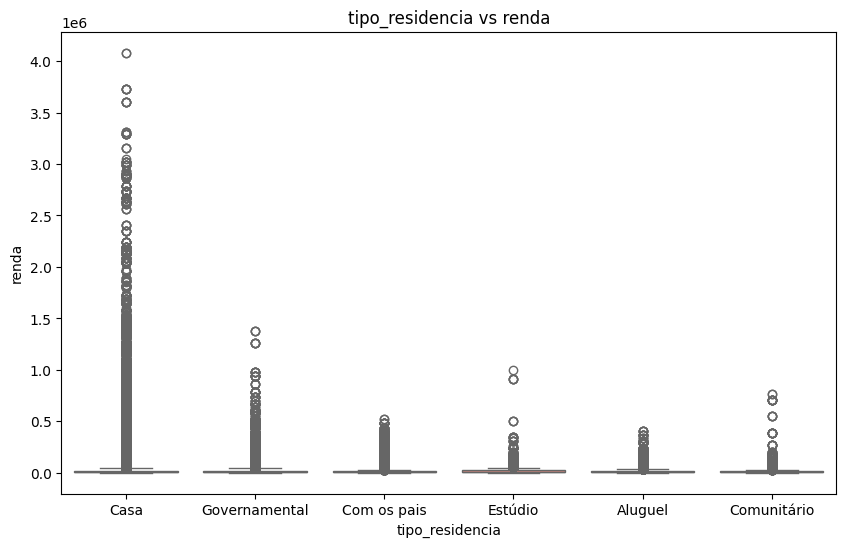


Correlação entre variáveis quantitativas:
                          idade  tempo_emprego  qt_pessoas_residencia  \
idade                  1.000000       0.330063              -0.341151   
tempo_emprego          0.330063       1.000000              -0.066361   
qt_pessoas_residencia -0.341151      -0.066361               1.000000   
qtd_filhos            -0.370234      -0.075299               0.890352   
renda                  0.101772       0.496360              -0.047790   

                       qtd_filhos     renda  
idade                   -0.370234  0.101772  
tempo_emprego           -0.075299  0.496360  
qt_pessoas_residencia    0.890352 -0.047790  
qtd_filhos               1.000000 -0.041886  
renda                   -0.041886  1.000000  


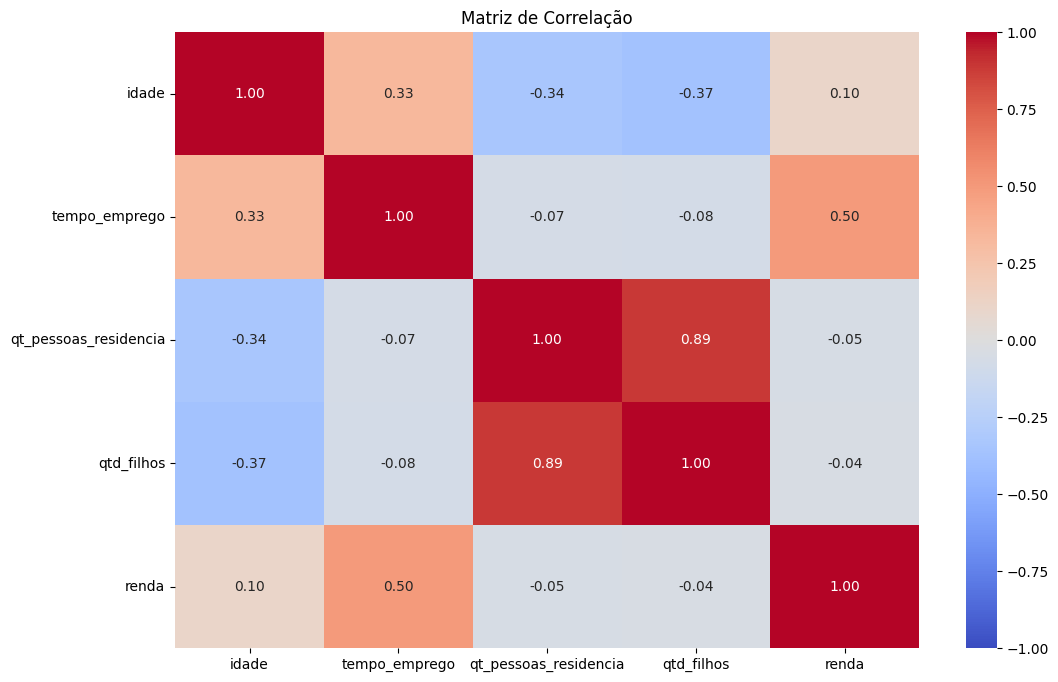

In [5]:
# Relação entre variáveis qualitativas
def cruzamento_qualitativas(var1, var2):
    print(f"\nCruzamento: {var1} vs {var2}")
    cruzamento = pd.crosstab(df[var1], df[var2], normalize='index') * 100
    print(cruzamento)
    cruzamento.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f"{var1} vs {var2}")
    plt.ylabel("Proporção (%)")
    plt.xlabel(var1)
    plt.legend(title=var2)
    plt.show()

# Relação entre qualitativa e quantitativa
def qualitativa_vs_quantitativa(cat_var, num_var):
    print(f"\nEstatísticas de {num_var} por categoria de {cat_var}:")
    resumo = df.groupby(cat_var)[num_var].describe()
    print(resumo)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_var, y=num_var, data=df, palette="Set3")
    plt.title(f"{cat_var} vs {num_var}")
    plt.show()

# Relação entre quantitativas
def correlacao_quantitativas(vars_quant):
    print("\nCorrelação entre variáveis quantitativas:")
    correlacao = df[vars_quant].corr()
    print(correlacao)
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title("Matriz de Correlação")
    plt.show()

# Lista de variáveis
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
variaveis_quantitativas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']

# Cruzamento entre variáveis qualitativas
for var1 in variaveis_qualitativas:
    for var2 in variaveis_qualitativas:
        if var1 != var2:
            cruzamento_qualitativas(var1, var2)

# Relação entre qualitativa e quantitativa
for cat_var in variaveis_qualitativas:
    for num_var in variaveis_quantitativas:
        qualitativa_vs_quantitativa(cat_var, num_var)

# Correlação entre variáveis quantitativas
correlacao_quantitativas(variaveis_quantitativas)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [6]:
missing_counts = df.isnull().sum()
print("Valores missing por coluna:\n", missing_counts)

Valores missing por coluna:
 data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64


In [7]:
# Substituir os valores ausentes de 'tempo_emprego' pela mediana
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

# Verificar novamente se há valores missing
missing_counts_after = df.isnull().sum()
print("Valores missing após o tratamento:\n", missing_counts_after)

Valores missing após o tratamento:
 data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [8]:
# Lista de variáveis numéricas a serem analisadas
numerical_vars = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']

# Função para tratar outliers
def treat_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Capping
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Aplicar tratamento para cada variável
for var in numerical_vars:
    treat_outliers(df, var)

# Verificar se houve alterações
for var in numerical_vars:
    print(f"{var} - Min: {df[var].min()}, Max: {df[var].max()}")

idade - Min: 22, Max: 68
tempo_emprego - Min: 0.1178082191780822, Max: 17.27260273972603
qt_pessoas_residencia - Min: 1.0, Max: 4.5
qtd_filhos - Min: 0.0, Max: 2.5
renda - Min: 107.67, Max: 40594.149999999994


In [9]:
# Identificar a quantidade de zeros em variáveis relevantes
zero_counts = df[['tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']].eq(0).sum()
print("Quantidade de zeros antes do tratamento:")
print(zero_counts)

# Tratar zeros incoerentes
df['tempo_emprego'] = df['tempo_emprego'].replace(0, None)  # Substituir zeros por None
df['renda'] = df['renda'].replace(0, None)                 # Substituir zeros por None

# Reimputar valores ausentes, se necessário (média para tempo_emprego e renda)
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
df['renda'] = df['renda'].fillna(df['renda'].mean())

# Verificar novamente os zeros após tratamento
zero_counts_after = df[['tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']].eq(0).sum()
print("\nQuantidade de zeros após o tratamento:")
print(zero_counts_after)

Quantidade de zeros antes do tratamento:
tempo_emprego                 0
qt_pessoas_residencia         0
qtd_filhos               517331
renda                         0
dtype: int64

Quantidade de zeros após o tratamento:
tempo_emprego                 0
qt_pessoas_residencia         0
qtd_filhos               517331
renda                         0
dtype: int64


In [10]:
# Agrupando categorias

# Agrupamento de `tipo_renda`
df['tipo_renda'] = df['tipo_renda'].replace({
    'Assalariado': 'Trabalhador',
    'Empresário': 'Trabalhador',
    'Pensionista': 'Beneficiário',
    'Servidor público': 'Trabalhador',
    'Bolsista': 'Outros'
})

# Agrupamento de `educacao`
df['educacao'] = df['educacao'].replace({
    'Médio': 'Ensino Médio',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior',
    'Fundamental': 'Fundamental ou Menor',
    'Pós graduação': 'Superior'
})

# Agrupamento de `estado_civil`
df['estado_civil'] = df['estado_civil'].replace({
    'Casado': 'Casado/União',
    'União': 'Casado/União',
    'Separado': 'Separado/Viúvo',
    'Viúvo': 'Separado/Viúvo',
    'Solteiro': 'Solteiro'
})

# Agrupamento de `tipo_residencia`
df['tipo_residencia'] = df['tipo_residencia'].replace({
    'Casa': 'Proprietário/Casa',
    'Comunitário': 'Outros',
    'Com os pais': 'Outros',
    'Governamental': 'Outros',
    'Estúdio': 'Outros',
    'Aluguel': 'Inquilino'
})

# Verificando as alterações
print("Categorias após agrupamento:")
print(df[['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']].nunique())

Categorias após agrupamento:
tipo_renda         3
educacao           3
estado_civil       3
tipo_residencia    3
dtype: int64


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [9]:
# Definindo variáveis explicativas e alvo
features = ['educacao', 'estado_civil', 'idade', 'posse_de_imovel', 'posse_de_veiculo',
            'qt_pessoas_residencia', 'qtd_filhos', 'renda', 'sexo', 'tempo_emprego',
            'tipo_renda', 'tipo_residencia']
target = 'mau'

In [10]:
# Separando dados para modelagem
train_data = df[df['data_ref'] < '2016-01-01']
oot_data = df[df['data_ref'] >= '2016-01-01']

In [11]:
# Amostrando apenas 5% dos dados para treinamento
train_data_sample = train_data.sample(frac=0.05, random_state=123)

In [12]:
# Configurando o PyCaret
clf_setup = setup(
    data=train_data_sample,
    target=target,
    session_id=123,
    numeric_features=['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'],
    fold=3  # Apenas 3 folds para validação cruzada
)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(30000, 15)"
4,Transformed data shape,"(30000, 34)"
5,Transformed train set shape,"(21000, 34)"
6,Transformed test set shape,"(9000, 34)"
7,Ordinal features,3
8,Numeric features,5
9,Date features,1


In [13]:
# Verificando configuração
setup_results = pull()
print(setup_results)

                    Description             Value
0                    Session id               123
1                        Target               mau
2                   Target type            Binary
3           Original data shape       (30000, 15)
4        Transformed data shape       (30000, 34)
5   Transformed train set shape       (21000, 34)
6    Transformed test set shape        (9000, 34)
7              Ordinal features                 3
8              Numeric features                 5
9                 Date features                 1
10         Categorical features                 7
11     Rows with missing values             17.0%
12                   Preprocess              True
13              Imputation type            simple
14           Numeric imputation              mean
15       Categorical imputation              mode
16     Maximum one-hot encoding                25
17              Encoding method              None
18               Fold Generator   StratifiedKFold


In [14]:
# Comparando modelos com otimização turbo e lista limitada de modelos
best_model = compare_models(sort='Accuracy', n_select=1, turbo=True, include=['lr', 'rf', 'lightgbm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9404,0.7703,0.0000,0.0000,0.0000,0.0000,0.0000,1.2000
lightgbm,Light Gradient Boosting Machine,0.9399,0.7435,0.0423,0.4518,0.0773,0.0679,0.1239,1.0900
rf,Random Forest Classifier,0.9354,0.7009,0.0391,0.2369,0.0671,0.0514,0.0748,1.0433


In [15]:
# Exibindo os resultados
model_results = pull()
print(model_results)

                                    Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9404  0.7703  0.0000  0.0000   
lightgbm  Light Gradient Boosting Machine    0.9399  0.7435  0.0423  0.4518   
rf               Random Forest Classifier    0.9354  0.7009  0.0391  0.2369   

              F1   Kappa     MCC  TT (Sec)  
lr        0.0000  0.0000  0.0000    1.2000  
lightgbm  0.0773  0.0679  0.1239    1.0900  
rf        0.0671  0.0514  0.0748    1.0433  


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [16]:
# Verificando valores nulos
null_values = train_data.isnull().sum()
print("Valores nulos por coluna:")
print(null_values)

Valores nulos por coluna:
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64


In [17]:
# Verificando a média e a mediana da variável 'tempo_emprego'
media_tempo_emprego = train_data['tempo_emprego'].mean()
mediana_tempo_emprego = train_data['tempo_emprego'].median()

print(f"Média de tempo_emprego: {media_tempo_emprego}")
print(f"Mediana de tempo_emprego: {mediana_tempo_emprego}")

# Decidindo qual utilizar (aqui utilizaremos a mediana como exemplo, substitua se necessário)
train_data['tempo_emprego'].fillna(mediana_tempo_emprego, inplace=True)

# Verificando se ainda há nulos após o tratamento
print("Valores nulos após tratamento de tempo_emprego:")
print(train_data['tempo_emprego'].isnull().sum())

Média de tempo_emprego: 7.747992318063461
Mediana de tempo_emprego: 6.046575342465753
Valores nulos após tratamento de tempo_emprego:
0


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [18]:
# Tratando outliers com substituição pelos limites inferior e superior
for var in ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Substituir os outliers pelos limites
    df[var] = df[var].apply(lambda x: lower_limit if x < lower_limit else (upper_limit if x > upper_limit else x))

# Verificando novamente a presença de outliers
for var in ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = df[(df[var] < lower_limit) | (df[var] > upper_limit)]
    print(f"Outliers restantes em {var}: {len(outliers)}")

Outliers restantes em idade: 0
Outliers restantes em tempo_emprego: 0
Outliers restantes em qt_pessoas_residencia: 0
Outliers restantes em qtd_filhos: 0
Outliers restantes em renda: 0


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

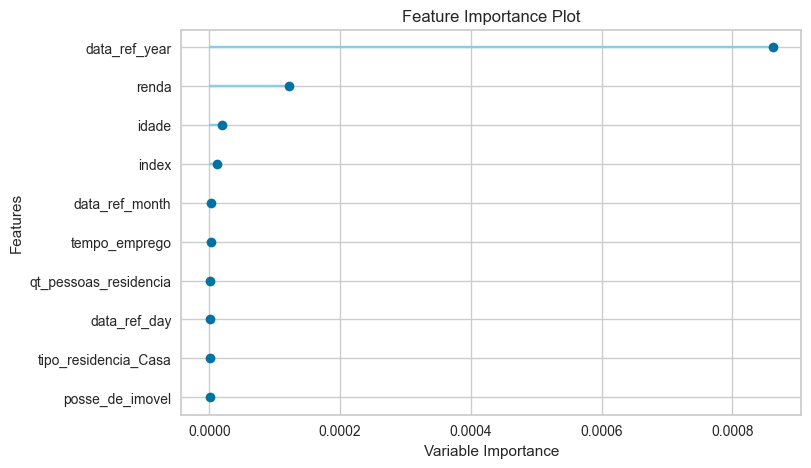

In [21]:
# Plotando a importância das variáveis
plot_model(best_model, plot='feature')

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [22]:
# Configurando o PyCaret com PCA
clf_setup_pca = setup(
    data=train_data_sample,  # Subconjunto de treinamento
    target=target,           # Variável-alvo
    session_id=123,          # Semente para reprodutibilidade
    numeric_features=['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'],  # Variáveis numéricas
    fold=3,                  # Número de folds para validação cruzada
    pca=True,                # Ativando PCA
    pca_components=5         # Reduzindo para 5 componentes principais
)

# Comparando os modelos com os dados reduzidos
best_model_pca = compare_models(sort='Accuracy', n_select=1)

# Exibindo os resultados
model_results_pca = pull()
print(model_results_pca)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(30000, 15)"
4,Transformed data shape,"(30000, 6)"
5,Transformed train set shape,"(21000, 6)"
6,Transformed test set shape,"(9000, 6)"
7,Ordinal features,3
8,Numeric features,5
9,Date features,1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9404,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3800
ada,Ada Boost Classifier,0.9404,0.7521,0.0359,0.5389,0.0665,0.0591,0.1229,0.7067
lda,Linear Discriminant Analysis,0.9404,0.6364,0.0000,0.0000,0.0000,0.0000,0.0000,0.4767
dummy,Dummy Classifier,0.9404,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5533
lightgbm,Light Gradient Boosting Machine,0.9394,0.7407,0.0415,0.4348,0.0751,0.0652,0.1178,0.6167
gbc,Gradient Boosting Classifier,0.9387,0.7651,0.0319,0.3388,0.0583,0.0488,0.0888,1.3833
rf,Random Forest Classifier,0.9368,0.7085,0.0503,0.3097,0.0865,0.0711,0.1045,0.9333
knn,K Neighbors Classifier,0.9361,0.6086,0.0503,0.2947,0.0855,0.0694,0.1001,0.9100
et,Extra Trees Classifier,0.9340,0.6654,0.0343,0.1958,0.0584,0.0413,0.0590,0.7833
dt,Decision Tree Classifier,0.8944,0.5503,0.1501,0.1397,0.1447,0.0885,0.0886,0.4500


                                    Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.9404  0.0000  0.0000  0.0000   
ada                  Ada Boost Classifier    0.9404  0.7521  0.0359  0.5389   
lda          Linear Discriminant Analysis    0.9404  0.6364  0.0000  0.0000   
dummy                    Dummy Classifier    0.9404  0.5000  0.0000  0.0000   
lightgbm  Light Gradient Boosting Machine    0.9394  0.7407  0.0415  0.4348   
gbc          Gradient Boosting Classifier    0.9387  0.7651  0.0319  0.3388   
rf               Random Forest Classifier    0.9368  0.7085  0.0503  0.3097   
knn                K Neighbors Classifier    0.9361  0.6086  0.0503  0.2947   
et                 Extra Trees Classifier    0.9340  0.6654  0.0343  0.1958   
dt               Decision Tree Classifier    0.8944  0.5503  0.1501  0.1397   
nb                            Naive Bayes    0.8128  0.6939  0.2740  0.1063   
qda       Quadratic Discriminant Analysis    0.6889 

In [23]:
# Selecionando o melhor modelo com base na métrica Accuracy
best_model = compare_models(sort='Accuracy', n_select=1)
print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9404,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4133
ada,Ada Boost Classifier,0.9404,0.7521,0.0359,0.5389,0.0665,0.0591,0.1229,0.7100
lda,Linear Discriminant Analysis,0.9404,0.6364,0.0000,0.0000,0.0000,0.0000,0.0000,0.4333
dummy,Dummy Classifier,0.9404,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4267
lightgbm,Light Gradient Boosting Machine,0.9394,0.7407,0.0415,0.4348,0.0751,0.0652,0.1178,0.5767
gbc,Gradient Boosting Classifier,0.9387,0.7651,0.0319,0.3388,0.0583,0.0488,0.0888,1.3067
rf,Random Forest Classifier,0.9368,0.7085,0.0503,0.3097,0.0865,0.0711,0.1045,0.9233
knn,K Neighbors Classifier,0.9361,0.6086,0.0503,0.2947,0.0855,0.0694,0.1001,0.5567
et,Extra Trees Classifier,0.9340,0.6654,0.0343,0.1958,0.0584,0.0413,0.0590,0.7200
dt,Decision Tree Classifier,0.8944,0.5503,0.1501,0.1397,0.1447,0.0885,0.0886,0.4433


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize='deprecated', positive=False,
                random_state=123, solver='auto', tol=0.001)


In [24]:
from pycaret.classification import save_model

# Salvando o modelo
save_model(best_model, 'melhor_modelo')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\mardo\AppData\Local\Temp\joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['idade', 'tempo_emprego',
                                              'qt_pessoas_residencia',
                                              'qtd_...
                  TransformerWrapper(exclude=[], include=None,
                                     transformer=PCA(copy=True,
                                                     iterated_power='auto',
                                   

In [26]:
# Fazendo previsões
predictions = predict_model(best_model, data=oot_data)
print(predictions.head())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8533,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


         data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
600000 2016-01-01   8906    F                S               S           2   
600001 2016-01-01   5063    F                N               S           0   
600002 2016-01-01  16401    M                S               S           1   
600003 2016-01-01   6786    F                N               S           1   
600004 2016-01-01  13466    M                S               N           0   

         tipo_renda           educacao estado_civil tipo_residencia  idade  \
600000  Assalariado  Superior completo       Casado            Casa     38   
600001  Assalariado              Médio       Casado            Casa     55   
600002  Assalariado              Médio        União            Casa     39   
600003  Assalariado              Médio        União     Com os pais     31   
600004  Assalariado              Médio       Casado            Casa     27   

        tempo_emprego  qt_pessoas_residencia         renda    

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [32]:
# Carregar o dataset se ainda não estiver carregado
# df = pd.read_feather('credit_scoring.ftr')

# Colunas categóricas a serem transformadas
categorical_columns = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel',
    'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
]

# Aplicando get_dummies
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Verificando o resultado
print(df_encoded.head())

# Salvando o dataframe transformado em um arquivo (opcional)
df_encoded.to_feather('credit_scoring_encoded.ftr')

    data_ref  index  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
0 2015-01-01   5733           0     43       6.873973                    1.0   
1 2015-01-01    727           0     35       4.526027                    2.0   
2 2015-01-01   6374           2     31       0.243836                    4.0   
3 2015-01-01   9566           0     54      12.772603                    2.0   
4 2015-01-01   9502           0     31       8.432877                    1.0   

      renda    mau  sexo_M  posse_de_veiculo_S  ...  \
0   2515.39  False       0                   0  ...   
1   3180.19  False       0                   1  ...   
2   1582.29  False       0                   0  ...   
3  13721.17  False       0                   0  ...   
4   2891.08  False       0                   1  ...   

   educacao_Superior incompleto  estado_civil_Separado  estado_civil_Solteiro  \
0                             0                      0                      1   
1                         

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [39]:
 def preprocessamento(df):
    # 1. Substituição de nulos
    def substituir_nulos(data):
        imputer = SimpleImputer(strategy='mean')
        data['tempo_emprego'] = imputer.fit_transform(data[['tempo_emprego']])
        return data

    # 2. Remoção de outliers (Exemplo: usando o IQR)
    def remover_outliers(data, columns):
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
        return data

    # 3. PCA para reduzir dimensionalidade
    def aplicar_pca(data, numeric_columns, n_components=5):
        scaler = StandardScaler()
        pca = PCA(n_components=n_components)
        scaled_data = scaler.fit_transform(data[numeric_columns])
        pca_data = pca.fit_transform(scaled_data)
        for i in range(n_components):
            data[f'pca_{i+1}'] = pca_data[:, i]
        return data.drop(columns=numeric_columns, axis=1)

    # 4. Criação de dummies
    def criar_dummies(data, categorical_columns):
        data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
        return data

    # Aplicando as etapas do pipeline
    df = substituir_nulos(df)
    df = remover_outliers(df, ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'])
    df = aplicar_pca(df, ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'])
    df = criar_dummies(df, ['posse_de_veiculo'])  # Exemplo para posse_de_veiculo

    return df


# Exemplo de uso
df = pd.read_feather('credit_scoring.ftr')
df_processed = preprocessamento(df)

# Salvando os dados pré-processados após redefinir o índice
df_processed.reset_index(drop=True, inplace=True)  # Redefine o índice para um padrão
df_processed.to_feather('credit_scoring_processed.ftr')  # Salva o arquivo em formato Feather

# Visualizando os dados processados
print(df_processed.head())

    data_ref  index sexo posse_de_imovel   tipo_renda             educacao  \
0 2015-01-01   5733    F               N   Empresário                Médio   
1 2015-01-01    727    F               S  Assalariado                Médio   
2 2015-01-01   6374    F               N  Assalariado                Médio   
3 2015-01-01   9566    F               N  Assalariado                Médio   
4 2015-01-01   9502    F               N  Assalariado  Superior incompleto   

  estado_civil tipo_residencia    mau     pca_1     pca_2     pca_3     pca_4  \
0     Solteiro            Casa  False -1.217827 -0.803477 -0.087691 -0.826601   
1       Casado            Casa  False -0.073135 -1.070088  0.301138 -0.584060   
2       Casado            Casa  False  3.684646 -1.022515 -0.497947  0.688324   
3       Casado            Casa  False -1.282079  1.725975 -0.514836 -0.498435   
4     Solteiro            Casa  False -0.840324 -0.671915  0.480650 -1.709315   

      pca_5  posse_de_veiculo_S  
0  0.54517

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import setup, compare_models, pull, plot_model, predict_model,create_model, tune_model, save_model, finalize_model
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [43]:
# Configurando o ambiente do PyCaret
clf_setup = setup(data=train_data,
                  target=target,
                  session_id=123,
                  numeric_features=['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'],
                  categorical_features=['educacao', 'estado_civil', 'posse_de_imovel', 'posse_de_veiculo', 
                                        'sexo', 'tipo_renda', 'tipo_residencia'],
                  preprocess=True)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 15)"
4,Transformed data shape,"(600000, 34)"
5,Transformed train set shape,"(420000, 34)"
6,Transformed test set shape,"(180000, 34)"
7,Ordinal features,3
8,Numeric features,5
9,Date features,1


In [ ]:
# Criar o modelo LightGBM
lightgbm_model = create_model('lightgbm')

# Ajustar o modelo automaticamente
tuned_lightgbm = tune_model(lightgbm_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9389,0.7643,0.0023,0.4615,0.0047,0.0040,0.0294
1,0.9388,0.7668,0.0031,0.4000,0.0062,0.0052,0.0309
2,0.9390,0.7684,0.0047,0.5714,0.0093,0.0083,0.0477
3,0.9387,0.7715,0.0035,0.3333,0.0069,0.0057,0.0288
4,0.9392,0.7627,0.0074,0.6786,0.0147,0.0134,0.0666
5,0.9388,0.7732,0.0016,0.3333,0.0031,0.0025,0.0192
6,0.9387,0.7618,0.0047,0.3529,0.0092,0.0076,0.0347
7,0.9389,0.7716,0.0055,0.5000,0.0108,0.0095,0.0473
8,0.9389,0.7713,0.0039,0.4545,0.0077,0.0067,0.0376


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:01:15
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# Finalizar o modelo para o uso em produção
final_lightgbm = finalize_model(tuned_lightgbm)

# Salvar o modelo
save_model(final_lightgbm, 'lightgbm_final_model')

In [ ]:
# Previsões no conjunto OOT
oot_predictions = predict_model(final_lightgbm, data=oot_data)

# Exibir as previsões
print(oot_predictions.head())

In [ ]:
# Matriz de Confusão
plot_model(final_lightgbm, plot='confusion_matrix')

# Curva ROC
plot_model(final_lightgbm, plot='auc')

# Feature Importance
plot_model(final_lightgbm, plot='feature')

# Error Analysis
plot_model(final_lightgbm, plot='error')

In [ ]:
# Carregar o modelo salvo
from pycaret.classification import load_model

loaded_model = load_model('lightgbm_final_model')

# Fazer previsões em novos dados
new_data_predictions = predict_model(loaded_model, data=oot_data)

# Exibir previsões
print(new_data_predictions.head())